# Prioritize notebook

In [12]:
import re
import string
import copy

def normalize_answer(s):

    def remove_articles(text):
        return re.sub(r'\b(a|an|the)\b', ' ', text)

    def white_space_fix(text):
        return ' '.join(text.split())

    def remove_punc(text):
        exclude = set(string.punctuation)
        return ''.join(ch for ch in text if ch not in exclude)

    def lower(text):
        return text.lower()

    return white_space_fix(remove_articles(remove_punc(lower(s))))

In [13]:
import json

# Load the raw data and question decompositions
raw_data = [json.loads(line.strip()) for line in open('./hotpotqa__v2_dev_random_100.jsonl')]
q2dq = json.load(open("./question_decompositions-devset.json"))

# Create q2gold map
q2gold = {}
for item in raw_data:
    try:
        question = item['question_text'].strip()
        question = list(q2dq[question].keys())[0]
        gold = item['answers_objects'][0]['spans'][0]
        q_type = item["type"]
        q2gold[question] = (gold, q_type)
    except Exception as e:
        # Skip if question not found in question_decompositions
        continue

# Load the data to analyze
with open('test-devset.json', 'r') as file:
    data = json.load(file)

# Initialize counters
correct_answers = 0
total_parent_nodes = 0
# Initialize lists to store logprobs
correct_logprobs = []
incorrect_logprobs = []

# Prepare the dataset
X = []  # Features (logprobs)
y = []  # Labels (1 for correct, 0 for incorrect)

# Loop through each example in the data
for example in data:
    for node in example:
        # Check if the node is a parent node (no "fa" entry)
        if "fa" not in node:
            total_parent_nodes += 1
            question_text = node.get("question_text", "").strip()
            answer = node.get("answer", [None])[0]  # Extract the cb_answer

            # Get the gold answer from q2gold
            if question_text in q2gold:
                gold_answer, _ = q2gold[question_text]
                print(f"Question: {question_text}, Gold: {gold_answer}, answer: {answer}")
                # Compare cb_answer_text with the gold answer
                if normalize_answer(answer) == normalize_answer(gold_answer):
                    correct_answers += 1


# Calculate the accuracy
accuracy = (correct_answers / total_parent_nodes) * 100 if total_parent_nodes > 0 else 0

# Print the results
print(f"Total parent nodes: {total_parent_nodes}")
print(f"Times answer matches gold answer: {correct_answers}")
print(f"correct answers match rate: {accuracy:.2f}%")

Question: What is the length of the river into which Pack Creek runs after it goes through the Spanish Valley?, Gold: 1450 mi, answer: Colorado River.
Question: North Midland Divisional Engineers took part in a battle during WWII that went on for how many weeks ?, Gold: six weeks, answer: 7.
Question: What trio was the songwriter of "What Are We Doin' Lonesome" from?, Gold: trio with his younger brothers Steve and Rudy, answer: a trio with his younger brothers Steve and Rudy.
Question: Baraki Barak District is situated in the western part of a province whose capital is what?, Gold: Puli Alam, answer: Logar.
Question: Atlas Shrugged was a film based on the books by a proponent of what philosophy?, Gold: Objectivism, answer: Objectivism.
Question: Which has more members, Dada or D-J?, Gold: Alt-J, answer: D-J.
Question: "She's a Mystery to Me" is a song on an album released in 1989 by what label?, Gold: Virgin, answer: Virgin.
Question: Jalen Jones plays basketball for an NBA team that p

# Closed book answers

In [14]:
import json

# Load the raw data and question decompositions
raw_data = [json.loads(line.strip()) for line in open('./hotpotqa__v2_dev_random_100.jsonl')]
q2dq = json.load(open("./question_decompositions-devset.json"))

# Create q2gold map
q2gold = {}
for item in raw_data:
    try:
        question = item['question_text'].strip()
        question = list(q2dq[question].keys())[0]
        gold = item['answers_objects'][0]['spans'][0]
        q_type = item["type"]
        q2gold[question] = (gold, q_type)
    except Exception as e:
        # Skip if question not found in question_decompositions
        continue

# Load the data to analyze
with open('test-devset.json', 'r') as file:
    data = json.load(file)

# Initialize counters
correct_cb_answers = 0
total_parent_nodes = 0
# Initialize lists to store logprobs
correct_logprobs = []
incorrect_logprobs = []
# Initialize lists to store lengths
correct_lengths = []
incorrect_lengths = []

# Prepare the dataset
X = []  # Features (logprobs)
y = []  # Labels (1 for correct, 0 for incorrect)

# Loop through each example in the data
for example in data:
    for node in example:
        # Check if the node is a parent node (no "fa" entry)
        if "fa" not in node:
            total_parent_nodes += 1
            question_text = node.get("question_text", "").strip()
            cb_answer = node.get("cb_answer", [None])  # Extract the cb_answer
            cb_answer_text = cb_answer[0]
            cb_logprob = cb_answer[1]  # Extract logprobs
            cb_logprobs = cb_answer[3]  # Extract logprobs, now i am taking the whole sequence

            # Get the gold answer from q2gold
            if question_text in q2gold:
                gold_answer, _ = q2gold[question_text]

                # Compare cb_answer_text with the gold answer
                if normalize_answer(cb_answer_text) == normalize_answer(gold_answer):
                    print(f"CB Answer: {cb_answer_text}, Gold Answer: {gold_answer} : Correct")
                    correct_cb_answers += 1
                    correct_logprobs.append(cb_logprob)  # Save logprobs for correct cases
                    correct_lengths.append(len(cb_logprobs))  # Save lengths for correct cases
                    # X.append([cb_logprob])  # Feature
                    X.append(cb_logprobs)  # Feature
                    y.append(1)  # Label (correct)

                else:
                    print(f"CB Answer: {cb_answer_text}, Gold Answer: {gold_answer} : Incorrect")
                    incorrect_logprobs.append(cb_logprob)  # Save logprobs for incorrect cases
                    incorrect_lengths.append(len(cb_logprobs))
                    # X.append([cb_logprob])  # Feature
                    X.append(cb_logprobs)  # Feature
                    y.append(0)  # Label (incorrect)

# Calculate the accuracy
accuracy = (correct_cb_answers / total_parent_nodes) * 100 if total_parent_nodes > 0 else 0

# Print the results
print(f"Total parent nodes: {total_parent_nodes}")
print(f"Times cb_answer matches gold answer: {correct_cb_answers}")
print(f"Closed-book match rate: {accuracy:.2f}%")

CB Answer: 134 miles., Gold Answer: 1450 mi : Incorrect
CB Answer: 16., Gold Answer: six weeks : Incorrect
CB Answer: Johnson's Creek., Gold Answer: trio with his younger brothers Steve and Rudy : Incorrect
CB Answer: Jhalawar., Gold Answer: Puli Alam : Incorrect
CB Answer: Objectivism., Gold Answer: Objectivism : Correct
CB Answer: Dada., Gold Answer: Alt-J : Incorrect
CB Answer: Capitol Records., Gold Answer: Virgin : Incorrect
CB Answer: Capital One Arena., Gold Answer: Smoothie King Center : Incorrect
CB Answer: Qualcomm Stadium., Gold Answer: Qualcomm : Incorrect
CB Answer: 1,300,000 square feet., Gold Answer: 1800000 sqft : Incorrect
CB Answer: no., Gold Answer: no : Correct
CB Answer: Bolshoi Theatre., Gold Answer: Bolshoi Theatre : Correct
CB Answer: the Olympics., Gold Answer: the 2016 World Indoor Championships : Incorrect
CB Answer: it allowed guests to star in their own music video., Gold Answer: the first to utilize Audio-Animatronics : Incorrect
CB Answer: handball., Gold

In [15]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import StandardScaler
import numpy as np

# Pad/truncate sequences to the maximum log prob sequence length
max_length = max(len(seq) for seq in X)
X_cb_padded = pad_sequences(X, maxlen=max_length, padding="post", truncating="post", value=-100, dtype="float32")

In [16]:
import numpy as np

# Calculate statistics for correct cases
correct_mean = np.mean(correct_logprobs) if correct_logprobs else 0
correct_std = np.std(correct_logprobs) if correct_logprobs else 0

# Calculate statistics for incorrect cases
incorrect_mean = np.mean(incorrect_logprobs) if incorrect_logprobs else 0
incorrect_std = np.std(incorrect_logprobs) if incorrect_logprobs else 0

# Print the results
print("Correct Cases:")
print(f"  Number of cases: {len(correct_logprobs)}")
print(f"  Mean logprobs: {correct_mean:.4f}")
print(f"  Standard deviation of logprobs: {correct_std:.4f}")

print("\nIncorrect Cases:")
print(f"  Number of cases: {len(incorrect_logprobs)}")
print(f"  Mean logprobs: {incorrect_mean:.4f}")
print(f"  Standard deviation of logprobs: {incorrect_std:.4f}")

Correct Cases:
  Number of cases: 30
  Mean logprobs: -0.0768
  Standard deviation of logprobs: 0.0393

Incorrect Cases:
  Number of cases: 65
  Mean logprobs: -0.0953
  Standard deviation of logprobs: 0.0529


Correct Cases:
  Number of cases: 30
  Mean logprobs: -0.0768
  Standard deviation of logprobs: 0.0393

Incorrect Cases:
  Number of cases: 65
  Mean logprobs: -0.0953
  Standard deviation of logprobs: 0.0529


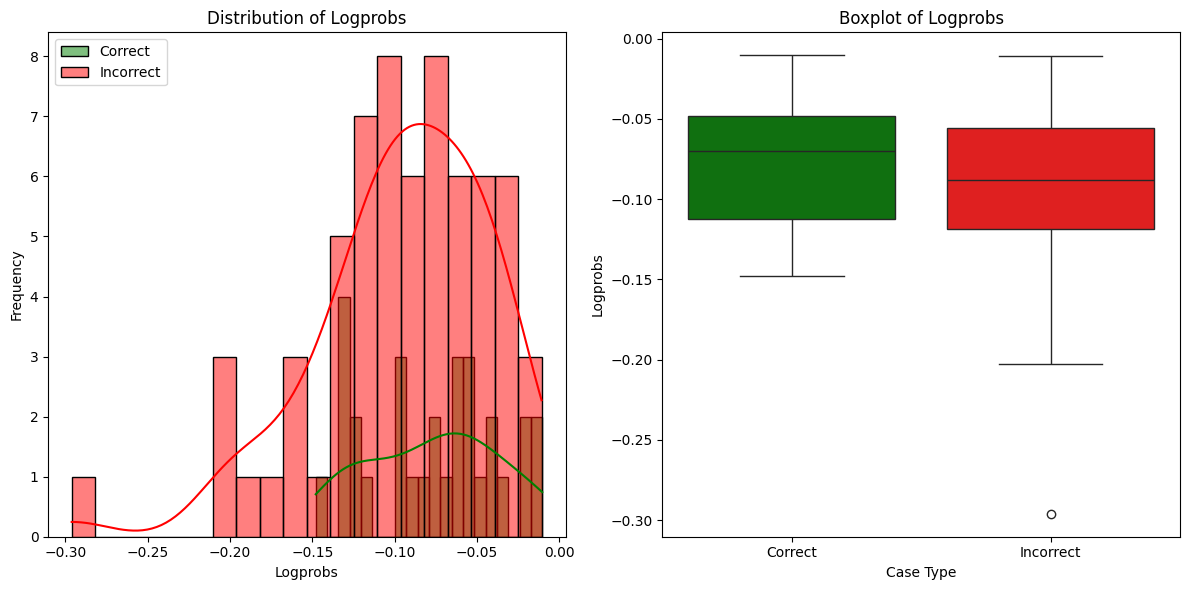

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns
# Calculate statistics for correct cases
correct_mean = np.mean(correct_logprobs) if correct_logprobs else 0
correct_std = np.std(correct_logprobs) if correct_logprobs else 0

# Calculate statistics for incorrect cases
incorrect_mean = np.mean(incorrect_logprobs) if incorrect_logprobs else 0
incorrect_std = np.std(incorrect_logprobs) if incorrect_logprobs else 0

# Print the results
print("Correct Cases:")
print(f"  Number of cases: {len(correct_logprobs)}")
print(f"  Mean logprobs: {correct_mean:.4f}")
print(f"  Standard deviation of logprobs: {correct_std:.4f}")

print("\nIncorrect Cases:")
print(f"  Number of cases: {len(incorrect_logprobs)}")
print(f"  Mean logprobs: {incorrect_mean:.4f}")
print(f"  Standard deviation of logprobs: {incorrect_std:.4f}")

# Visualizations
plt.figure(figsize=(12, 6))

# Histogram of logprobs for correct and incorrect cases
plt.subplot(1, 2, 1)
sns.histplot(correct_logprobs, color="green", label="Correct", kde=True, bins=20)
sns.histplot(incorrect_logprobs, color="red", label="Incorrect", kde=True, bins=20)
plt.title("Distribution of Logprobs")
plt.xlabel("Logprobs")
plt.ylabel("Frequency")
plt.legend()

# Boxplot of logprobs for correct and incorrect cases
plt.subplot(1, 2, 2)
sns.boxplot(data=[correct_logprobs, incorrect_logprobs], palette=["green", "red"])
plt.xticks([0, 1], ["Correct", "Incorrect"])
plt.title("Boxplot of Logprobs")
plt.xlabel("Case Type")
plt.ylabel("Logprobs")

plt.tight_layout()
plt.show()


In [18]:
# Compute mean and standard deviation
cb_logprob_correct_mean = np.mean(correct_logprobs)
cb_logprob_correct_std = np.std(correct_logprobs)
cb_logprob_incorrect_mean = np.mean(incorrect_logprobs)
cb_logprob_incorrect_std = np.std(incorrect_logprobs)

print("Correct - Mean:", cb_logprob_correct_mean, "Std:", cb_logprob_correct_std)
print("Incorrect - Mean:", cb_logprob_incorrect_mean, "Std:", cb_logprob_incorrect_std)

Correct - Mean: -0.07680483787536982 Std: 0.03934458742637571
Incorrect - Mean: -0.09532811263015356 Std: 0.05288494906530584


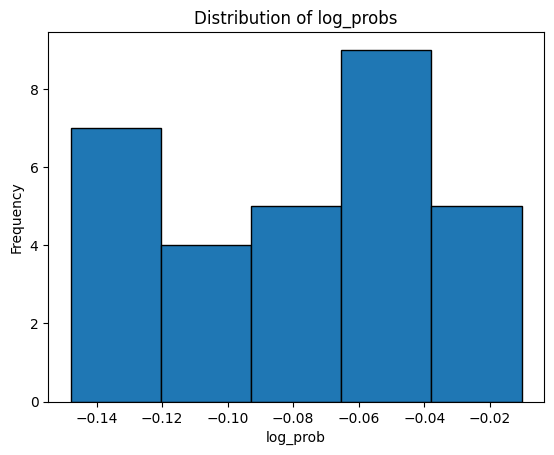

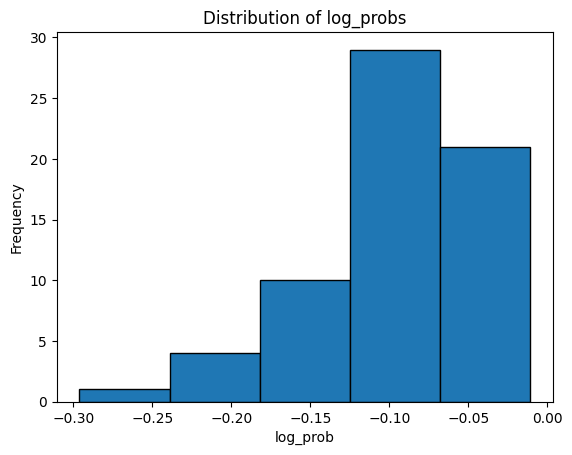

In [19]:
import matplotlib.pyplot as plt

# Plot histogram of log_probs
plt.hist(correct_logprobs, bins=5, edgecolor='black')
plt.title("Distribution of log_probs")
plt.xlabel("log_prob")
plt.ylabel("Frequency")
plt.show()

# Plot histogram of log_probs
plt.hist(incorrect_logprobs, bins=5, edgecolor='black')
plt.title("Distribution of log_probs")
plt.xlabel("log_prob")
plt.ylabel("Frequency")
plt.show()

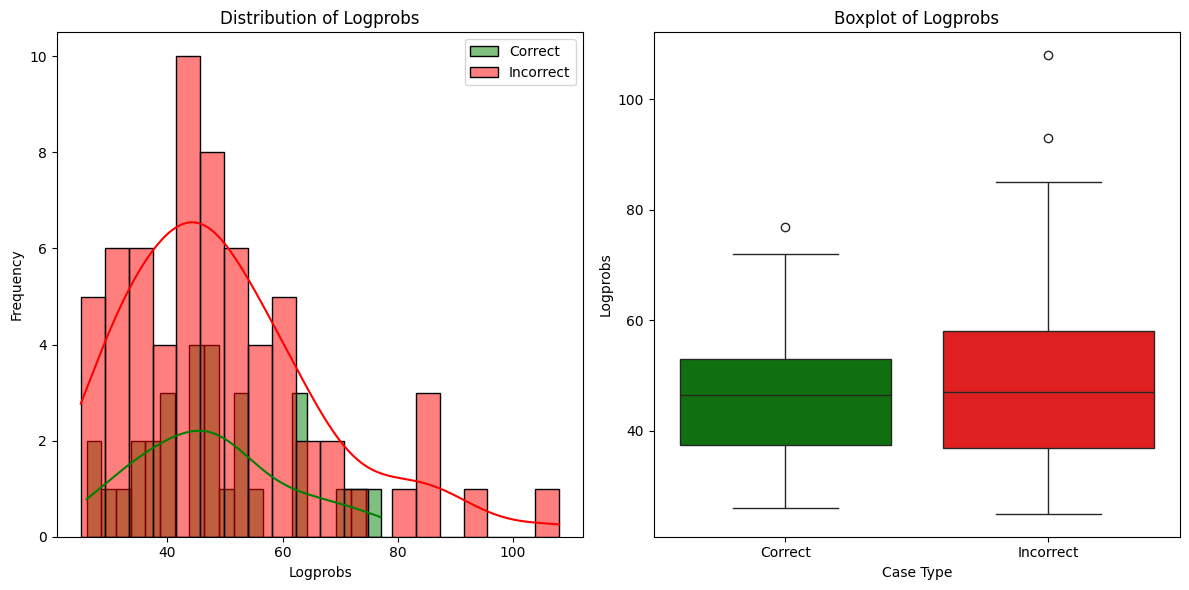

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns

# Visualizations
plt.figure(figsize=(12, 6))

# Histogram of logprobs for correct and incorrect cases
plt.subplot(1, 2, 1)
sns.histplot(correct_lengths, color="green", label="Correct", kde=True, bins=20)
sns.histplot(incorrect_lengths, color="red", label="Incorrect", kde=True, bins=20)
plt.title("Distribution of Logprobs")
plt.xlabel("Logprobs")
plt.ylabel("Frequency")
plt.legend()

# Boxplot of logprobs for correct and incorrect cases
plt.subplot(1, 2, 2)
sns.boxplot(data=[correct_lengths, incorrect_lengths], palette=["green", "red"])
plt.xticks([0, 1], ["Correct", "Incorrect"])
plt.title("Boxplot of Logprobs")
plt.xlabel("Case Type")
plt.ylabel("Logprobs")

plt.tight_layout()
plt.show()


In [21]:
# Compute mean and standard deviation
cb_length_correct_mean = np.mean(correct_lengths)
cb_length_correct_std = np.std(correct_lengths)
cb_length_incorrect_mean = np.mean(incorrect_lengths)
cb_length_incorrect_std = np.std(incorrect_lengths)

print("Correct - Mean:", cb_length_correct_mean, "Std:", cb_length_correct_std)
print("Incorrect - Mean:", cb_length_incorrect_mean, "Std:", cb_length_incorrect_std)

Correct - Mean: 47.53333333333333 Std: 12.86787559087444
Incorrect - Mean: 49.723076923076924 Std: 17.21493778206116


Class Distribution: [65 30]
Model Evaluation (Adjusted Threshold): 0.0
  Accuracy: 0.4737
  Precision: 0.4737
  Recall: 1.0000
  F1-Score: 0.6429
  ROC AUC: 0.6222


/opt/homebrew/anaconda3/envs/advanced_nlp/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


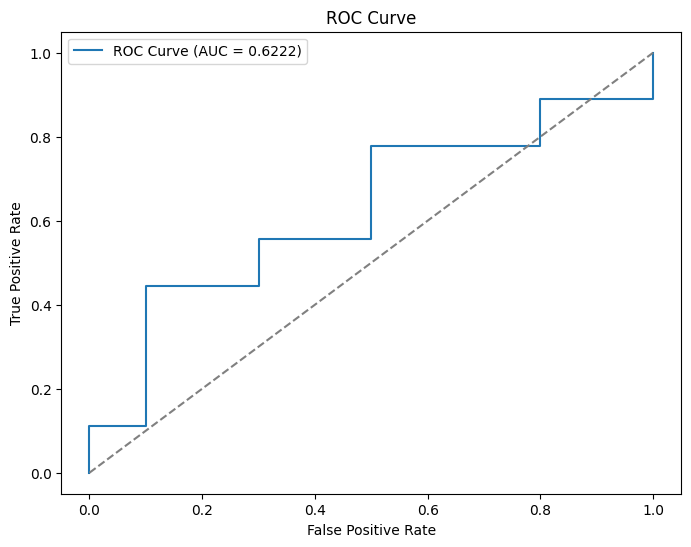

Model Evaluation (Adjusted Threshold): 0.1
  Accuracy: 0.6316
  Precision: 0.6667
  Recall: 0.4444
  F1-Score: 0.5333
  ROC AUC: 0.6222


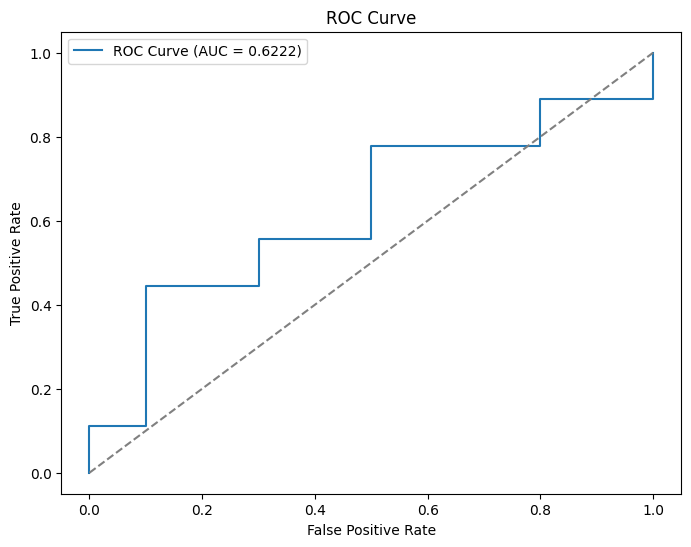

Model Evaluation (Adjusted Threshold): 0.2
  Accuracy: 0.6316
  Precision: 0.6667
  Recall: 0.4444
  F1-Score: 0.5333
  ROC AUC: 0.6222


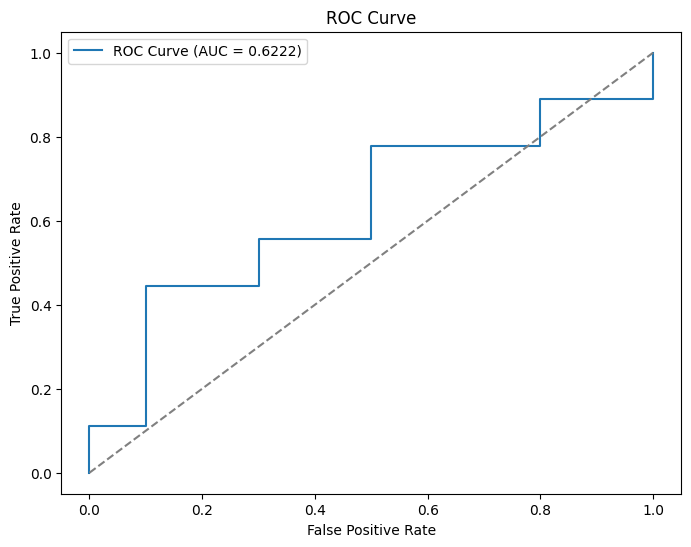

Model Evaluation (Adjusted Threshold): 0.3
  Accuracy: 0.6316
  Precision: 0.6667
  Recall: 0.4444
  F1-Score: 0.5333
  ROC AUC: 0.6222


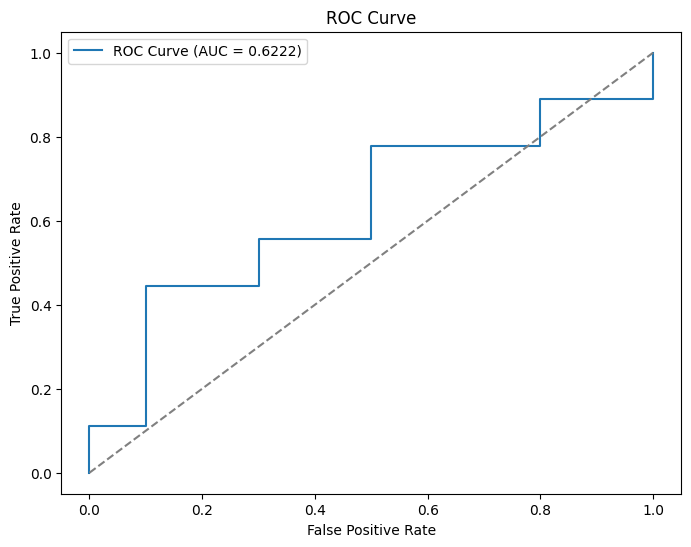

Model Evaluation (Adjusted Threshold): 0.4
  Accuracy: 0.6316
  Precision: 0.7500
  Recall: 0.3333
  F1-Score: 0.4615
  ROC AUC: 0.6222


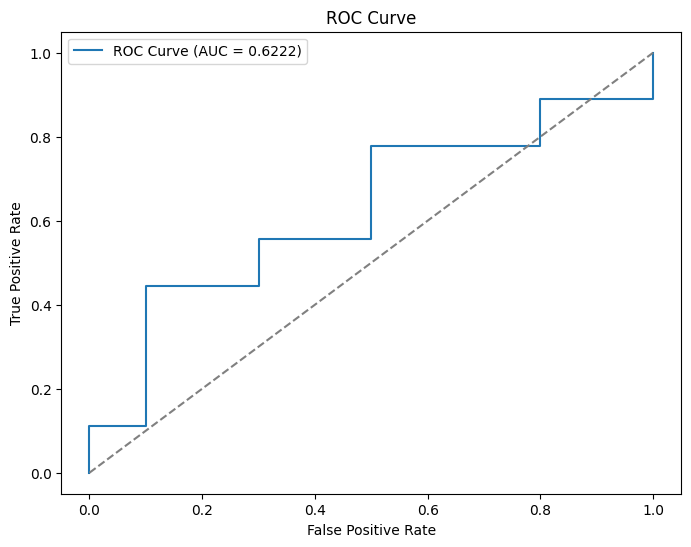

Model Evaluation (Adjusted Threshold): 0.5
  Accuracy: 0.6316
  Precision: 0.7500
  Recall: 0.3333
  F1-Score: 0.4615
  ROC AUC: 0.6222


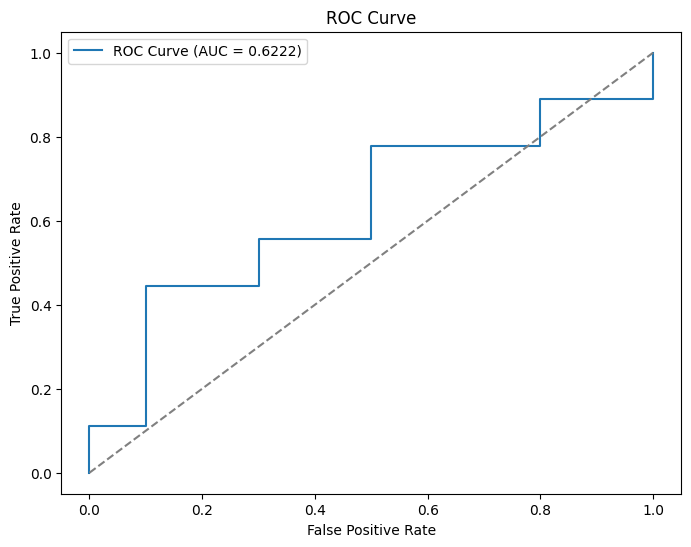

Model Evaluation (Adjusted Threshold): 0.6
  Accuracy: 0.6316
  Precision: 0.7500
  Recall: 0.3333
  F1-Score: 0.4615
  ROC AUC: 0.6222


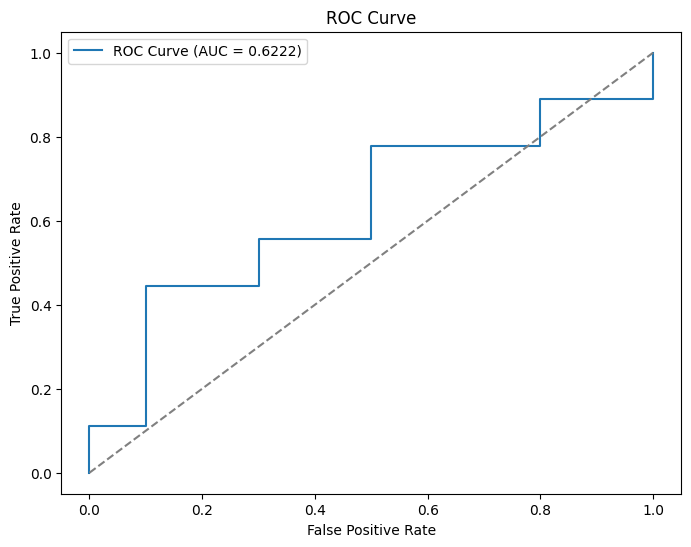

Model Evaluation (Adjusted Threshold): 0.7
  Accuracy: 0.5263
  Precision: 0.5000
  Recall: 0.1111
  F1-Score: 0.1818
  ROC AUC: 0.6222


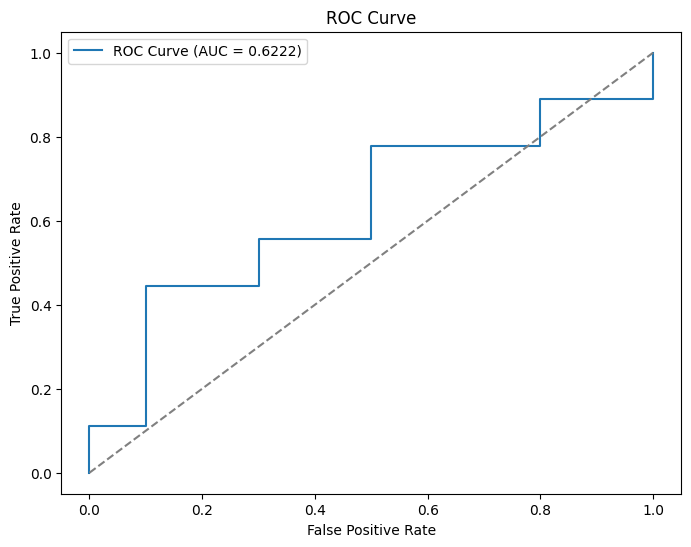

Model Evaluation (Adjusted Threshold): 0.8
  Accuracy: 0.5263
  Precision: 0.5000
  Recall: 0.1111
  F1-Score: 0.1818
  ROC AUC: 0.6222


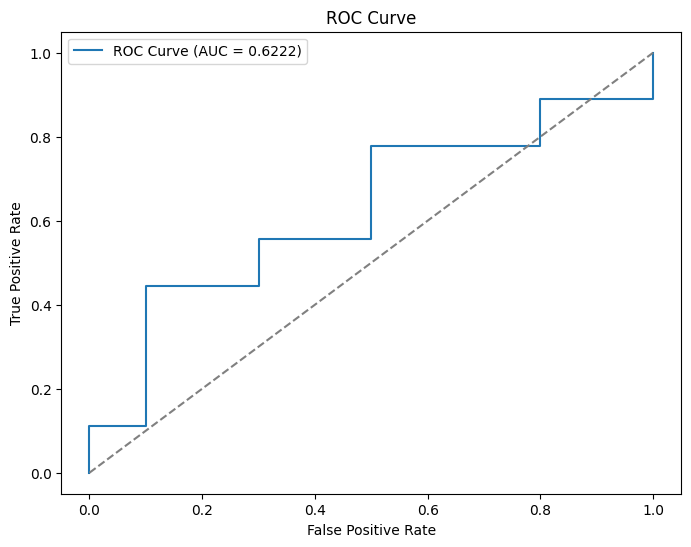

Model Evaluation (Adjusted Threshold): 0.9
  Accuracy: 0.5263
  Precision: 0.5000
  Recall: 0.1111
  F1-Score: 0.1818
  ROC AUC: 0.6222


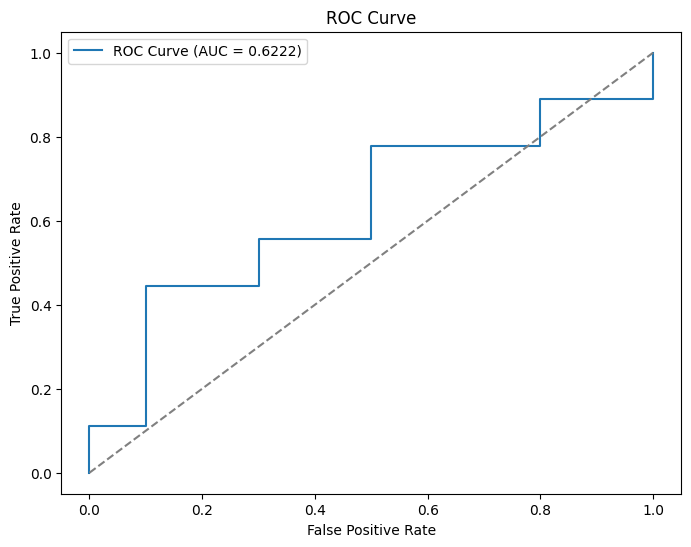

In [22]:
# import numpy as np
# import pandas as pd
# from sklearn.model_selection import train_test_split
# from sklearn.linear_model import LogisticRegression
# from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve
# import matplotlib.pyplot as plt


# # Convert to numpy arrays
# X = np.array(X)
# y = np.array(y)

# # Split the data into training and testing sets
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# # Check class distribution
# print("Class Distribution:", np.bincount(y))

# # Train a Logistic Regression model with class weights
# model = LogisticRegression(class_weight="balanced")
# model.fit(X_train, y_train)

# # Make predictions
# y_pred_proba = model.predict_proba(X_test)[:, 1]  # Probabilities for ROC curve

# # Adjust threshold
# threshold = 0.3  # Experiment with different thresholds
# y_pred_adj = (y_pred_proba >= threshold).astype(int)

# # Evaluate the model
# accuracy = accuracy_score(y_test, y_pred_adj)
# precision = precision_score(y_test, y_pred_adj)
# recall = recall_score(y_test, y_pred_adj)
# f1 = f1_score(y_test, y_pred_adj)
# roc_auc = roc_auc_score(y_test, y_pred_proba)

# print("Model Evaluation (Adjusted Threshold):")
# print(f"  Accuracy: {accuracy:.4f}")
# print(f"  Precision: {precision:.4f}")
# print(f"  Recall: {recall:.4f}")
# print(f"  F1-Score: {f1:.4f}")
# print(f"  ROC AUC: {roc_auc:.4f}")

# # Plot the ROC curve
# fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
# plt.figure(figsize=(8, 6))
# plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc:.4f})")
# plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
# plt.xlabel("False Positive Rate")
# plt.ylabel("True Positive Rate")
# plt.title("ROC Curve")
# plt.legend()
# plt.show()


import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve
import matplotlib.pyplot as plt


# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_cb_padded, y, test_size=0.2, random_state=42)

# Check class distribution
print("Class Distribution:", np.bincount(y))

# Train a Logistic Regression model with class weights
model = LogisticRegression(class_weight="balanced")
model.fit(X_train, y_train)

# Make predictions
y_pred_proba = model.predict_proba(X_test)[:, 1]  # Probabilities for ROC curve

# Adjust threshold
for i in range(0, 10):
    threshold = i/10  # Experiment with different thresholds
    # threshold = 0.2  # Experiment with different thresholds
    y_pred_adj = (y_pred_proba >= threshold).astype(int)

    # Evaluate the model
    accuracy = accuracy_score(y_test, y_pred_adj)
    precision = precision_score(y_test, y_pred_adj)
    recall = recall_score(y_test, y_pred_adj)
    f1 = f1_score(y_test, y_pred_adj)
    roc_auc = roc_auc_score(y_test, y_pred_proba)

    print(f"Model Evaluation (Adjusted Threshold): {threshold}")
    print(f"  Accuracy: {accuracy:.4f}")
    print(f"  Precision: {precision:.4f}")
    print(f"  Recall: {recall:.4f}")
    print(f"  F1-Score: {f1:.4f}")
    print(f"  ROC AUC: {roc_auc:.4f}")

    # Plot the ROC curve
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc:.4f})")
    plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve")
    plt.legend()
    plt.show()

# Child answer

In [23]:
import json

# Load the data to analyze
with open('test-devset.json', 'r') as file:
    data = json.load(file)

# Initialize counters
correct_child_answers = 0
total_parent_nodes = 0
# Initialize lists to store logprobs
correct_logprobs = []
incorrect_logprobs = []
# Initialize lists to store lengths
correct_lengths = []
incorrect_lengths = []

# Prepare the dataset
X = []  # Features (logprobs)
y = []  # Labels (1 for correct, 0 for incorrect)

# Loop through each example in the data
for example in data:
    for node in example:
        # Check if the node is a parent node (no "fa" entry)
        if "fa" not in node:
            total_parent_nodes += 1
            question_text = node.get("question_text", "").strip()
            child_answer = node.get("child_answer", [None])  # Extract the child_answer
            child_answer_text = child_answer[0]
            child_logprob = child_answer[1]  # Extract logprobs
            child_logprobs = child_answer[3]  # Extract logprobs

            # Get the gold answer from q2gold
            if question_text in q2gold:
                gold_answer, _ = q2gold[question_text]

                # Compare child_answer_text with the gold answer
                if normalize_answer(child_answer_text) == normalize_answer(gold_answer):
                    print(f"OB Answer: {child_answer_text}, Gold Answer: {gold_answer} : Correct")
                    correct_child_answers += 1
                    correct_logprobs.append(child_logprob)  # Save logprobs for correct cases
                    correct_lengths.append(len(child_logprobs))
                    # X.append([child_logprob])  # Feature
                    X.append(child_logprobs)  # Feature
                    y.append(1)  # Label (correct)
                else:
                    print(f"OB Answer: {child_answer_text}, Gold Answer: {gold_answer} : Incorrect")
                    if child_logprob > -10:
                        incorrect_logprobs.append(child_logprob)  # Save logprobs for incorrect cases
                        incorrect_lengths.append(len(child_logprobs))
                        # X.append([child_logprob])  # Feature
                        X.append(child_logprobs)  # Feature
                        y.append(0)  # Label (incorrect)

# Calculate the accuracy
accuracy = (correct_child_answers / total_parent_nodes) * 100 if total_parent_nodes > 0 else 0

# Print the results
print(f"Total parent nodes: {total_parent_nodes}")
print(f"Times child_answer matches gold answer: {correct_child_answers}")
print(f"Open-book match rate: {accuracy:.2f}%")

OB Answer: 1450 mi., Gold Answer: 1450 mi : Correct
OB Answer: 7., Gold Answer: six weeks : Incorrect
OB Answer: a trio with his younger brothers Steve and Rudy., Gold Answer: trio with his younger brothers Steve and Rudy : Correct
OB Answer: Puli Alam., Gold Answer: Puli Alam : Correct
OB Answer: Ayn Rand., Gold Answer: Objectivism : Incorrect
OB Answer: D-J., Gold Answer: Alt-J : Incorrect
OB Answer: Virgin., Gold Answer: Virgin : Correct
OB Answer: Smoothie King Center., Gold Answer: Smoothie King Center : Correct
OB Answer: Qualcomm Stadium., Gold Answer: Qualcomm : Incorrect
OB Answer: 146,000 square feet., Gold Answer: 1800000 sqft : Incorrect
OB Answer: no., Gold Answer: no : Correct
OB Answer: Bolshoi Theatre., Gold Answer: Bolshoi Theatre : Correct
OB Answer: the Olympics., Gold Answer: the 2016 World Indoor Championships : Incorrect
OB Answer: it was the first Circle-Vision show with a plot and Audio-Animatronics., Gold Answer: the first to utilize Audio-Animatronics : Incorr

Correct Cases:
  Number of cases: 40
  Mean logprobs: -0.0544
  Standard deviation of logprobs: 0.0237

Incorrect Cases:
  Number of cases: 52
  Mean logprobs: -0.0751
  Standard deviation of logprobs: 0.0310


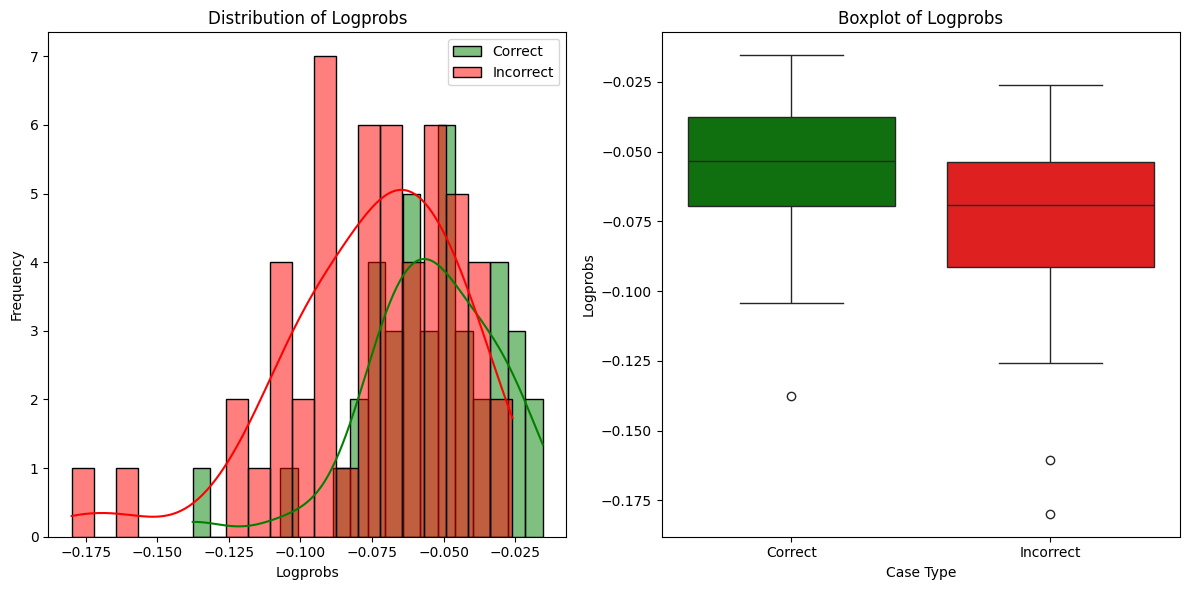

In [24]:
import matplotlib.pyplot as plt
import seaborn as sns
# Calculate statistics for correct cases
correct_mean = np.mean(correct_logprobs) if correct_logprobs else 0
correct_std = np.std(correct_logprobs) if correct_logprobs else 0

# Calculate statistics for incorrect cases
incorrect_mean = np.mean(incorrect_logprobs) if incorrect_logprobs else 0
incorrect_std = np.std(incorrect_logprobs) if incorrect_logprobs else 0

# Print the results
print("Correct Cases:")
print(f"  Number of cases: {len(correct_logprobs)}")
print(f"  Mean logprobs: {correct_mean:.4f}")
print(f"  Standard deviation of logprobs: {correct_std:.4f}")

print("\nIncorrect Cases:")
print(f"  Number of cases: {len(incorrect_logprobs)}")
print(f"  Mean logprobs: {incorrect_mean:.4f}")
print(f"  Standard deviation of logprobs: {incorrect_std:.4f}")

# Visualizations
plt.figure(figsize=(12, 6))

# Histogram of logprobs for correct and incorrect cases
plt.subplot(1, 2, 1)
sns.histplot(correct_logprobs, color="green", label="Correct", kde=True, bins=20)
sns.histplot(incorrect_logprobs, color="red", label="Incorrect", kde=True, bins=20)
plt.title("Distribution of Logprobs")
plt.xlabel("Logprobs")
plt.ylabel("Frequency")
plt.legend()

# Boxplot of logprobs for correct and incorrect cases
plt.subplot(1, 2, 2)
sns.boxplot(data=[correct_logprobs, incorrect_logprobs], palette=["green", "red"])
plt.xticks([0, 1], ["Correct", "Incorrect"])
plt.title("Boxplot of Logprobs")
plt.xlabel("Case Type")
plt.ylabel("Logprobs")

plt.tight_layout()
plt.show()


In [25]:
# Compute mean and standard deviation
child_logprob_correct_mean = np.mean(correct_logprobs)
child_logprob_correct_std = np.std(correct_logprobs)
child_logprob_incorrect_mean = np.mean(incorrect_logprobs)
child_logprob_incorrect_std = np.std(incorrect_logprobs)

print("Correct - Mean:", child_logprob_correct_mean, "Std:", child_logprob_correct_std)
print("Incorrect - Mean:", child_logprob_incorrect_mean, "Std:", child_logprob_incorrect_std)

Correct - Mean: -0.054436924925766725 Std: 0.02366890829099565
Incorrect - Mean: -0.07513576894466435 Std: 0.03097057694890552


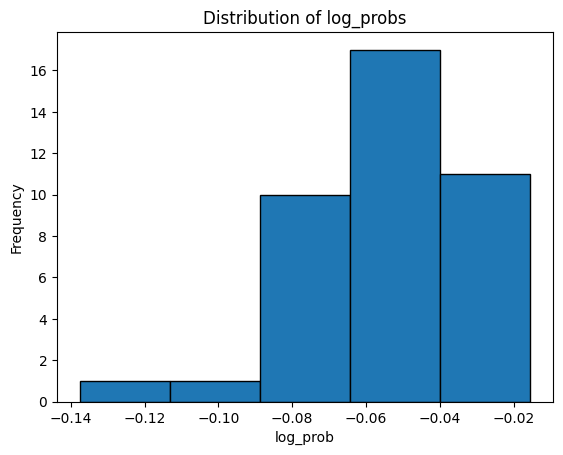

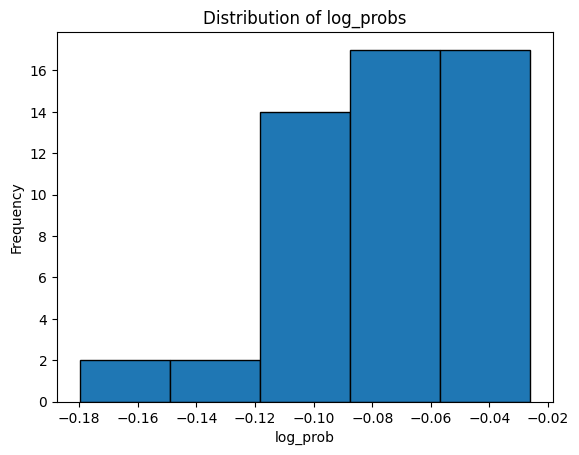

In [26]:
import matplotlib.pyplot as plt

# Plot histogram of log_probs
plt.hist(correct_logprobs, bins=5, edgecolor='black')
plt.title("Distribution of log_probs")
plt.xlabel("log_prob")
plt.ylabel("Frequency")
plt.show()

# Plot histogram of log_probs
plt.hist(incorrect_logprobs, bins=5, edgecolor='black')
plt.title("Distribution of log_probs")
plt.xlabel("log_prob")
plt.ylabel("Frequency")
plt.show()

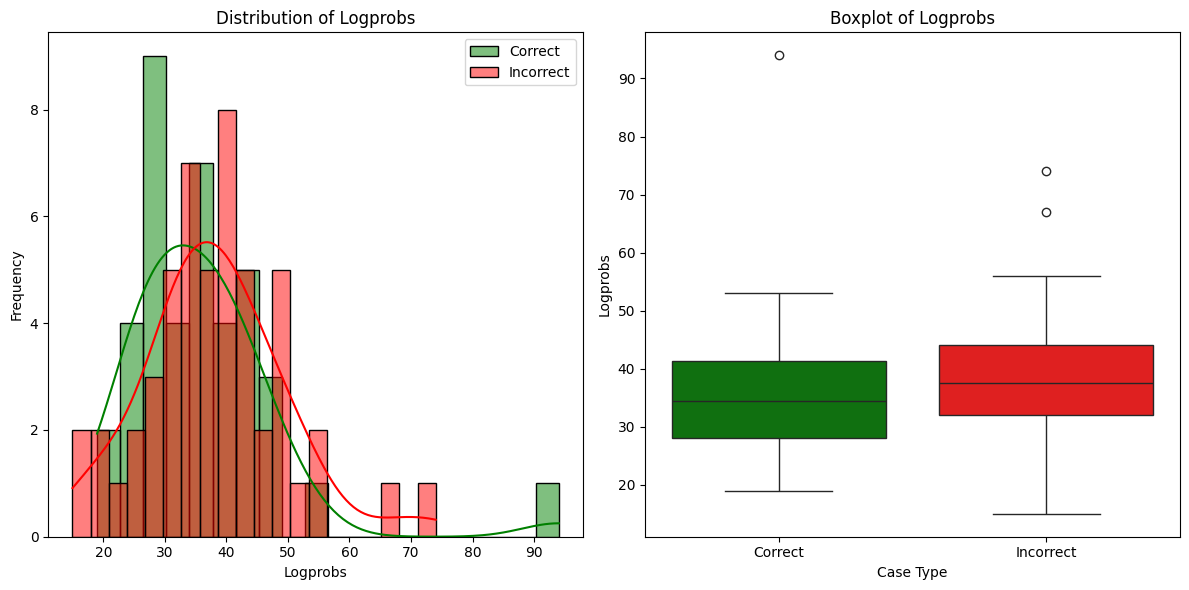

In [27]:
import matplotlib.pyplot as plt
import seaborn as sns

# Visualizations
plt.figure(figsize=(12, 6))

# Histogram of logprobs for correct and incorrect cases
plt.subplot(1, 2, 1)
sns.histplot(correct_lengths, color="green", label="Correct", kde=True, bins=20)
sns.histplot(incorrect_lengths, color="red", label="Incorrect", kde=True, bins=20)
plt.title("Distribution of Logprobs")
plt.xlabel("Logprobs")
plt.ylabel("Frequency")
plt.legend()

# Boxplot of logprobs for correct and incorrect cases
plt.subplot(1, 2, 2)
sns.boxplot(data=[correct_lengths, incorrect_lengths], palette=["green", "red"])
plt.xticks([0, 1], ["Correct", "Incorrect"])
plt.title("Boxplot of Logprobs")
plt.xlabel("Case Type")
plt.ylabel("Logprobs")

plt.tight_layout()
plt.show()

In [28]:
# Compute mean and standard deviation
child_length_correct_mean = np.mean(correct_lengths)
child_length_correct_std = np.std(correct_lengths)
child_length_incorrect_mean = np.mean(incorrect_lengths)
child_length_incorrect_std = np.std(incorrect_lengths)

print("Correct - Mean:", child_length_correct_mean, "Std:", child_length_correct_std)
print("Incorrect - Mean:", child_length_incorrect_mean, "Std:", child_length_incorrect_std)

Correct - Mean: 36.0 Std: 12.269881825021788
Incorrect - Mean: 38.11538461538461 Std: 11.348761108518623


# Openbook answer

In [29]:
import json

# Load the data to analyze
with open('test-devset.json', 'r') as file:
    data = json.load(file)

# Initialize counters
correct_ob_answers = 0
total_parent_nodes = 0
# Initialize lists to store logprobs
correct_logprobs = []
incorrect_logprobs = []
# Initialize lists to store lengths
correct_lengths = []
incorrect_lengths = []

# Prepare the dataset
X = []  # Features (logprobs)
y = []  # Labels (1 for correct, 0 for incorrect)

# Loop through each example in the data
for example in data:
    for node in example:
        # Check if the node is a parent node (no "fa" entry)
        if "fa" not in node:
            total_parent_nodes += 1
            question_text = node.get("question_text", "").strip()
            ob_answer = node.get("ob_answer", [None])  # Extract the ob_answer
            ob_answer_text = ob_answer[0]
            ob_logprob = ob_answer[1]  # Extract logprobs
            ob_logprobs = ob_answer[3]  # Extract logprobs

            # Get the gold answer from q2gold
            if question_text in q2gold:
                gold_answer, _ = q2gold[question_text]

                # Compare ob_answer_text with the gold answer
                if normalize_answer(ob_answer_text) == normalize_answer(gold_answer):
                    print(f"OB Answer: {ob_answer_text}, Gold Answer: {gold_answer} : Correct")
                    correct_ob_answers += 1
                    correct_logprobs.append(ob_logprob)  # Save logprobs for correct cases
                    correct_lengths.append(len(ob_logprobs))
                    # X.append([ob_logprob])  # Feature
                    X.append(ob_logprobs)  # Feature
                    y.append(1)  # Label (correct)
                else:
                    print(f"OB Answer: {ob_answer_text}, Gold Answer: {gold_answer} : Incorrect")
                    if ob_logprob > -10:
                        incorrect_logprobs.append(ob_logprob)  # Save logprobs for incorrect cases
                        incorrect_lengths.append(len(ob_logprobs))
                        # X.append([ob_logprob])  # Feature
                        X.append(ob_logprobs)  # Feature
                        y.append(0)  # Label (incorrect)

# Calculate the accuracy
accuracy = (correct_ob_answers / total_parent_nodes) * 100 if total_parent_nodes > 0 else 0

# Print the results
print(f"Total parent nodes: {total_parent_nodes}")
print(f"Times ob_answer matches gold answer: {correct_ob_answers}")
print(f"Open-book match rate: {accuracy:.2f}%")

OB Answer: Colorado River., Gold Answer: 1450 mi : Incorrect
OB Answer: Unknown., Gold Answer: six weeks : Incorrect
OB Answer: Larry Gatlin., Gold Answer: trio with his younger brothers Steve and Rudy : Incorrect
OB Answer: Logar., Gold Answer: Puli Alam : Incorrect
OB Answer: Objectivism., Gold Answer: Objectivism : Correct
OB Answer: Unknown., Gold Answer: Alt-J : Incorrect
OB Answer: Unknown., Gold Answer: Virgin : Incorrect
OB Answer: Unknown., Gold Answer: Smoothie King Center : Incorrect
OB Answer: The 2017 San Diego State Aztecs football team plays their home games at SDCCU Stadium. Unknown., Gold Answer: Qualcomm : Incorrect
OB Answer: Unknown., Gold Answer: 1800000 sqft : Incorrect
OB Answer: No., Gold Answer: no : Correct
OB Answer: Bolshoi Theatre., Gold Answer: Bolshoi Theatre : Correct
OB Answer: 2016 World Indoor Championships., Gold Answer: the 2016 World Indoor Championships : Correct
OB Answer: It was a Circle-Vision attraction., Gold Answer: the first to utilize Audi

Correct Cases:
  Number of cases: 30
  Mean logprobs: -0.0570
  Standard deviation of logprobs: 0.0340

Incorrect Cases:
  Number of cases: 48
  Mean logprobs: -0.0783
  Standard deviation of logprobs: 0.0488


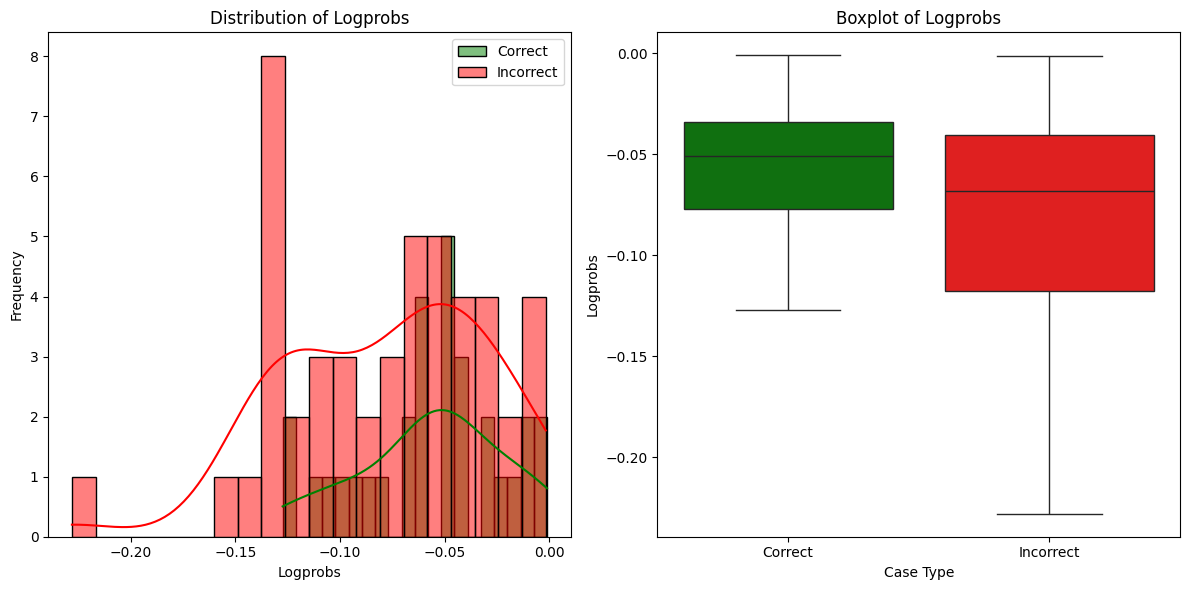

In [30]:
import matplotlib.pyplot as plt
import seaborn as sns

# Calculate statistics for correct cases
correct_mean = np.mean(correct_logprobs) if correct_logprobs else 0
correct_std = np.std(correct_logprobs) if correct_logprobs else 0

# Calculate statistics for incorrect cases
incorrect_mean = np.mean(incorrect_logprobs) if incorrect_logprobs else 0
incorrect_std = np.std(incorrect_logprobs) if incorrect_logprobs else 0

# Print the results
print("Correct Cases:")
print(f"  Number of cases: {len(correct_logprobs)}")
print(f"  Mean logprobs: {correct_mean:.4f}")
print(f"  Standard deviation of logprobs: {correct_std:.4f}")

print("\nIncorrect Cases:")
print(f"  Number of cases: {len(incorrect_logprobs)}")
print(f"  Mean logprobs: {incorrect_mean:.4f}")
print(f"  Standard deviation of logprobs: {incorrect_std:.4f}")

# Visualizations
plt.figure(figsize=(12, 6))

# Histogram of logprobs for correct and incorrect cases
plt.subplot(1, 2, 1)
sns.histplot(correct_logprobs, color="green", label="Correct", kde=True, bins=20)
sns.histplot(incorrect_logprobs, color="red", label="Incorrect", kde=True, bins=20)
plt.title("Distribution of Logprobs")
plt.xlabel("Logprobs")
plt.ylabel("Frequency")
plt.legend()

# Boxplot of logprobs for correct and incorrect cases
plt.subplot(1, 2, 2)
sns.boxplot(data=[correct_logprobs, incorrect_logprobs], palette=["green", "red"])
plt.xticks([0, 1], ["Correct", "Incorrect"])
plt.title("Boxplot of Logprobs")
plt.xlabel("Case Type")
plt.ylabel("Logprobs")

plt.tight_layout()
plt.show()

In [31]:
# Compute mean and standard deviation
ob_logprob_correct_mean = np.mean(correct_logprobs)
ob_logprob_correct_std = np.std(correct_logprobs)
ob_logprob_incorrect_mean = np.mean(incorrect_logprobs)
ob_logprob_incorrect_std = np.std(incorrect_logprobs)

print("Correct - Mean:", ob_logprob_correct_mean, "Std:", ob_logprob_correct_std)
print("Incorrect - Mean:", ob_logprob_incorrect_mean, "Std:", ob_logprob_incorrect_std)

Correct - Mean: -0.0569541789615392 Std: 0.033996466253518945
Incorrect - Mean: -0.07834734215214656 Std: 0.04883579115379777


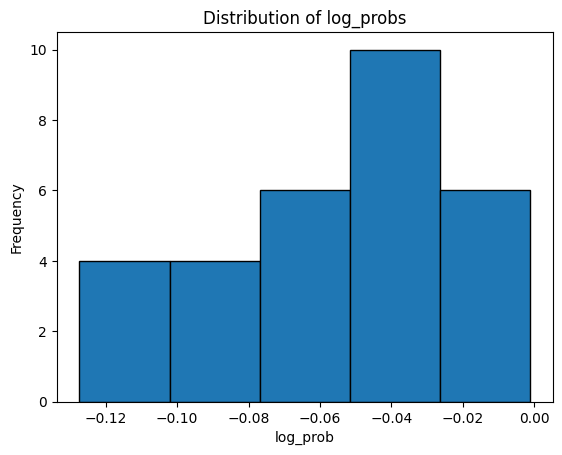

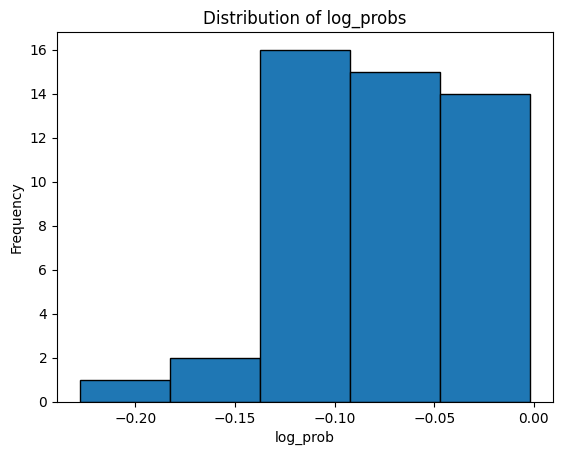

In [32]:
import matplotlib.pyplot as plt

# Plot histogram of log_probs
plt.hist(correct_logprobs, bins=5, edgecolor='black')
plt.title("Distribution of log_probs")
plt.xlabel("log_prob")
plt.ylabel("Frequency")
plt.show()

# Plot histogram of log_probs
plt.hist(incorrect_logprobs, bins=5, edgecolor='black')
plt.title("Distribution of log_probs")
plt.xlabel("log_prob")
plt.ylabel("Frequency")
plt.show()

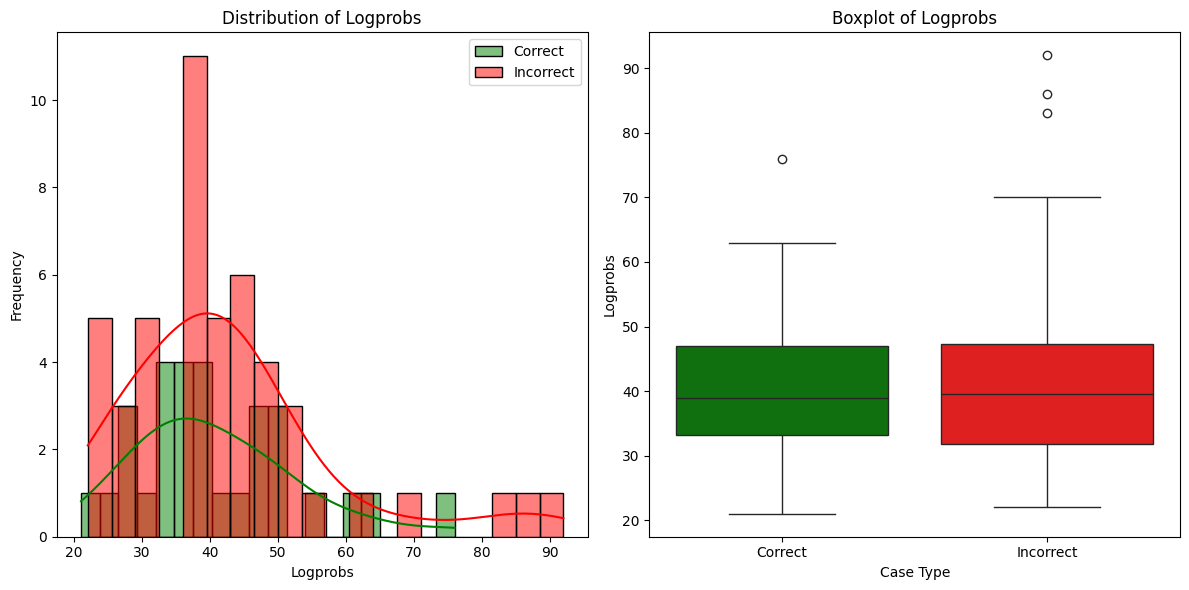

In [33]:
import matplotlib.pyplot as plt
import seaborn as sns

# Visualizations
plt.figure(figsize=(12, 6))

# Histogram of logprobs for correct and incorrect cases
plt.subplot(1, 2, 1)
sns.histplot(correct_lengths, color="green", label="Correct", kde=True, bins=20)
sns.histplot(incorrect_lengths, color="red", label="Incorrect", kde=True, bins=20)
plt.title("Distribution of Logprobs")
plt.xlabel("Logprobs")
plt.ylabel("Frequency")
plt.legend()

# Boxplot of logprobs for correct and incorrect cases
plt.subplot(1, 2, 2)
sns.boxplot(data=[correct_lengths, incorrect_lengths], palette=["green", "red"])
plt.xticks([0, 1], ["Correct", "Incorrect"])
plt.title("Boxplot of Logprobs")
plt.xlabel("Case Type")
plt.ylabel("Logprobs")

plt.tight_layout()
plt.show()

In [34]:
# Compute mean and standard deviation
ob_length_correct_mean = np.mean(correct_lengths)
ob_length_correct_std = np.std(correct_lengths)
ob_length_incorrect_mean = np.mean(incorrect_lengths)
ob_length_incorrect_std = np.std(incorrect_lengths)

print("Correct - Mean:", ob_length_correct_mean, "Std:", ob_length_correct_std)
print("Incorrect - Mean:", ob_length_incorrect_mean, "Std:", ob_length_incorrect_std)

Correct - Mean: 40.766666666666666 Std: 11.859407892283473
Incorrect - Mean: 42.541666666666664 Std: 15.24926000026085


In [35]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Pad/truncate sequences to the maximum log prob sequence length
max_length = max(len(seq) for seq in X)
X_ob_padded = pad_sequences(X, maxlen=max_length, padding="post", truncating="post", value=-100, dtype="float32")
X_ob_padded

array([[-5.27343750e-02, -7.98702240e-06, -6.54296875e-02, ...,
        -1.00000000e+02, -1.00000000e+02, -1.00000000e+02],
       [-4.72656250e-01, -1.19209290e-07,  0.00000000e+00, ...,
        -1.00000000e+02, -1.00000000e+02, -1.00000000e+02],
       [-3.16406250e-01, -4.29687500e-01, -1.04904175e-04, ...,
        -1.00000000e+02, -1.00000000e+02, -1.00000000e+02],
       ...,
       [-7.53906250e-01, -3.45706940e-06, -1.19209290e-07, ...,
        -1.00000000e+02, -1.00000000e+02, -1.00000000e+02],
       [-1.05957031e-01, -1.78813934e-06,  0.00000000e+00, ...,
        -1.00000000e+02, -1.00000000e+02, -1.00000000e+02],
       [-4.46777344e-02,  0.00000000e+00,  0.00000000e+00, ...,
        -1.00000000e+02, -1.00000000e+02, -1.00000000e+02]], dtype=float32)

Class Distribution: [48 30]
Model Evaluation (Adjusted Threshold):
  Accuracy: 0.3125
  Precision: 0.3077
  Recall: 0.6667
  F1-Score: 0.4211
  ROC AUC: 0.2833


/opt/homebrew/anaconda3/envs/advanced_nlp/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


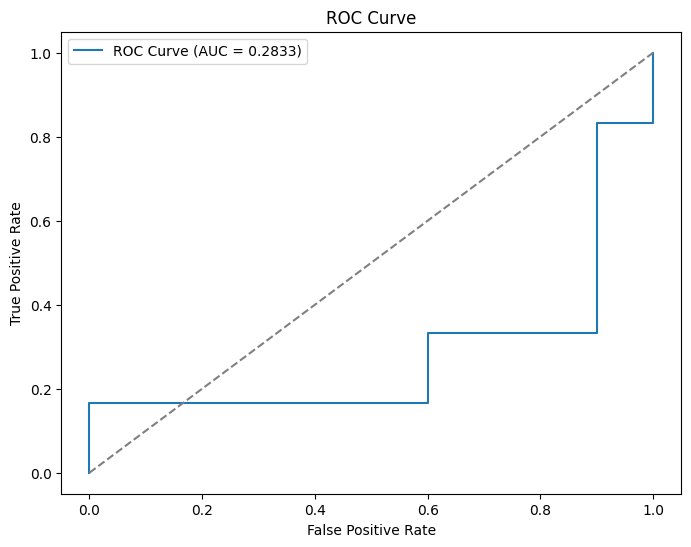

Model Evaluation (Adjusted Threshold):
  Accuracy: 0.3125
  Precision: 0.3077
  Recall: 0.6667
  F1-Score: 0.4211
  ROC AUC: 0.2833


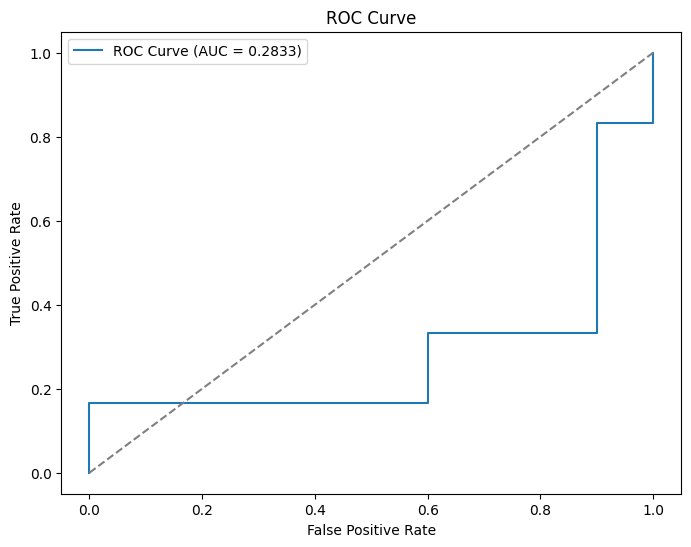

Model Evaluation (Adjusted Threshold):
  Accuracy: 0.3125
  Precision: 0.3077
  Recall: 0.6667
  F1-Score: 0.4211
  ROC AUC: 0.2833


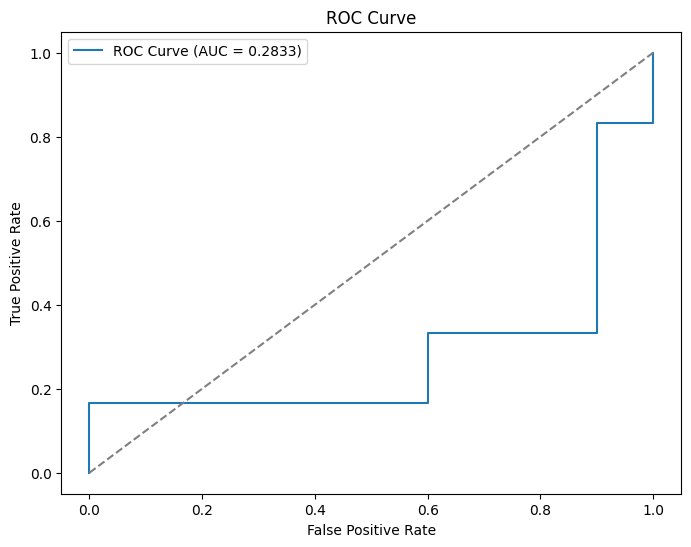

Model Evaluation (Adjusted Threshold):
  Accuracy: 0.3125
  Precision: 0.3077
  Recall: 0.6667
  F1-Score: 0.4211
  ROC AUC: 0.2833


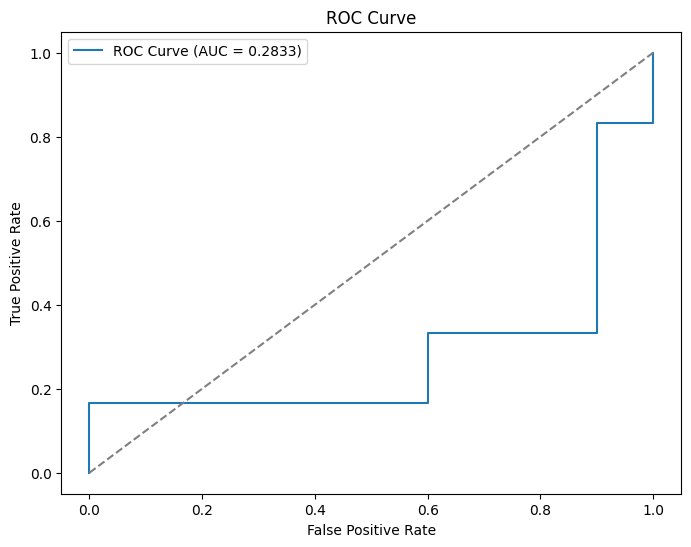

Model Evaluation (Adjusted Threshold):
  Accuracy: 0.3125
  Precision: 0.3077
  Recall: 0.6667
  F1-Score: 0.4211
  ROC AUC: 0.2833


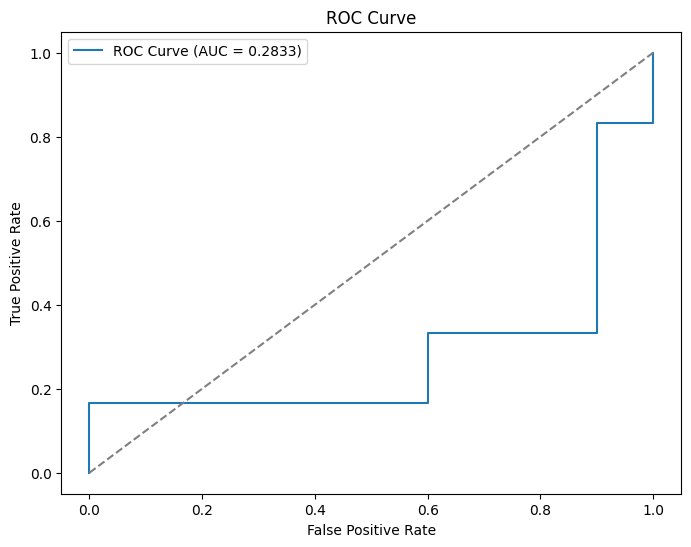

Model Evaluation (Adjusted Threshold):
  Accuracy: 0.3125
  Precision: 0.2222
  Recall: 0.3333
  F1-Score: 0.2667
  ROC AUC: 0.2833


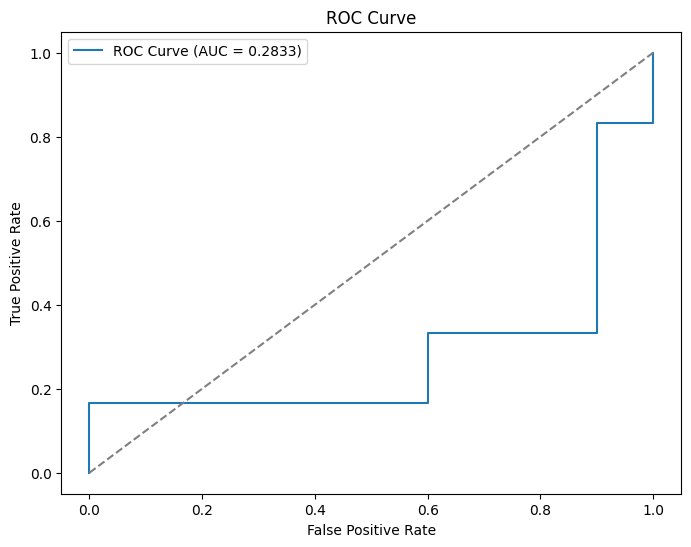

Model Evaluation (Adjusted Threshold):
  Accuracy: 0.5625
  Precision: 0.3333
  Recall: 0.1667
  F1-Score: 0.2222
  ROC AUC: 0.2833


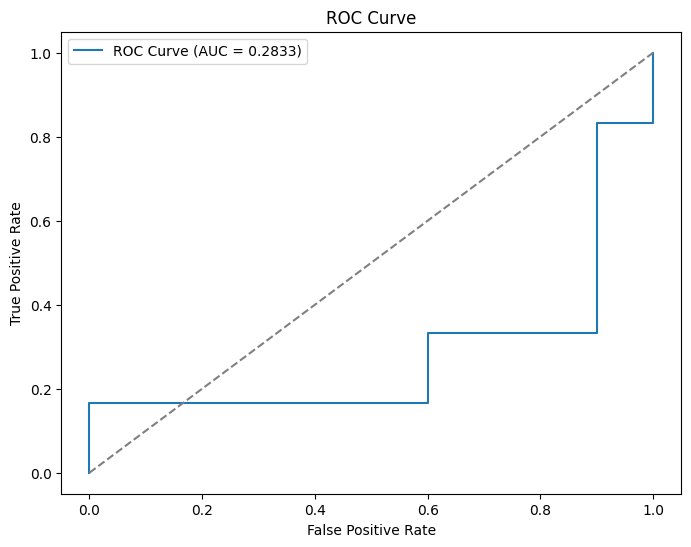

Model Evaluation (Adjusted Threshold):
  Accuracy: 0.6875
  Precision: 1.0000
  Recall: 0.1667
  F1-Score: 0.2857
  ROC AUC: 0.2833


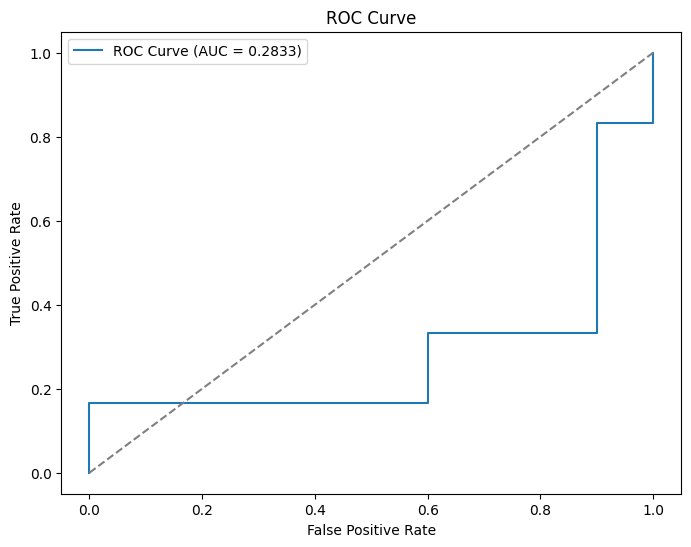

Model Evaluation (Adjusted Threshold):
  Accuracy: 0.6875
  Precision: 1.0000
  Recall: 0.1667
  F1-Score: 0.2857
  ROC AUC: 0.2833


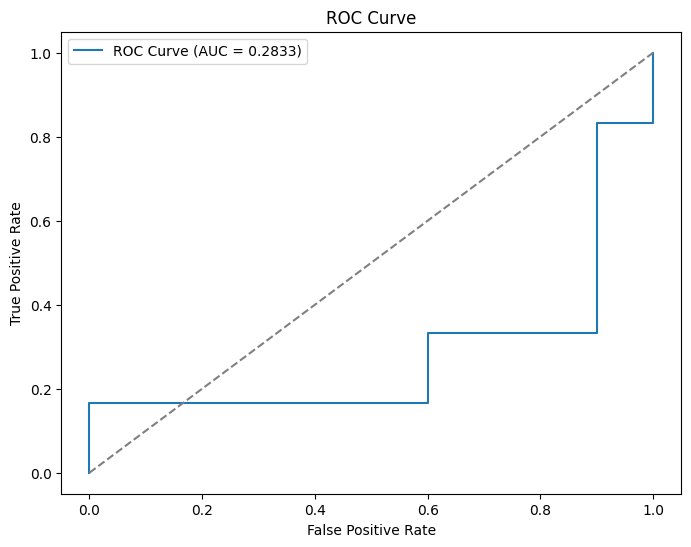

In [36]:
# import numpy as np
# import pandas as pd
# from sklearn.model_selection import train_test_split
# from sklearn.linear_model import LogisticRegression
# from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve
# import matplotlib.pyplot as plt

# # Convert to numpy arrays
# X = np.array(X)
# y = np.array(y)

# # Split the data into training and testing sets
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# # Check class distribution
# print("Class Distribution:", np.bincount(y))

# # Train a Logistic Regression model with class weights
# model = LogisticRegression(class_weight="balanced")
# model.fit(X_train, y_train)

# # Make predictions
# y_pred_proba = model.predict_proba(X_test)[:, 1]  # Probabilities for ROC curve

# # Adjust threshold
# threshold = 0.3  # Experiment with different thresholds
# y_pred_adj = (y_pred_proba >= threshold).astype(int)

# # Evaluate the model
# accuracy = accuracy_score(y_test, y_pred_adj)
# precision = precision_score(y_test, y_pred_adj)
# recall = recall_score(y_test, y_pred_adj)
# f1 = f1_score(y_test, y_pred_adj)
# roc_auc = roc_auc_score(y_test, y_pred_proba)

# print("Model Evaluation (Adjusted Threshold):")
# print(f"  Accuracy: {accuracy:.4f}")
# print(f"  Precision: {precision:.4f}")
# print(f"  Recall: {recall:.4f}")
# print(f"  F1-Score: {f1:.4f}")
# print(f"  ROC AUC: {roc_auc:.4f}")

# # Plot the ROC curve
# fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
# plt.figure(figsize=(8, 6))
# plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc:.4f})")
# plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
# plt.xlabel("False Positive Rate")
# plt.ylabel("True Positive Rate")
# plt.title("ROC Curve")
# plt.legend()
# plt.show()



import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve
import matplotlib.pyplot as plt



# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_ob_padded, y, test_size=0.2, random_state=42)

# Check class distribution
print("Class Distribution:", np.bincount(y))

# Train a Logistic Regression model with class weights
model = LogisticRegression(class_weight="balanced")
model.fit(X_train, y_train)

# Make predictions
y_pred_proba = model.predict_proba(X_test)[:, 1]  # Probabilities for ROC curve

# loop on thresholds from 0.1 to 0.9
for i in range(1, 10):
    threshold = i / 10

    # Adjust threshold
    # threshold = i  # Experiment with different thresholds
    y_pred_adj = (y_pred_proba >= threshold).astype(int)

    # Evaluate the model
    accuracy = accuracy_score(y_test, y_pred_adj)
    precision = precision_score(y_test, y_pred_adj)
    recall = recall_score(y_test, y_pred_adj)
    f1 = f1_score(y_test, y_pred_adj)
    roc_auc = roc_auc_score(y_test, y_pred_proba)

    print("Model Evaluation (Adjusted Threshold):")
    print(f"  Accuracy: {accuracy:.4f}")
    print(f"  Precision: {precision:.4f}")
    print(f"  Recall: {recall:.4f}")
    print(f"  F1-Score: {f1:.4f}")
    print(f"  ROC AUC: {roc_auc:.4f}")

    # Plot the ROC curve
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc:.4f})")
    plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve")
    plt.legend()
    plt.show()

In [37]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression

# Prepare the dataset (X and y from previous steps)
# X: logprobs, y: labels (1 for correct, 0 for incorrect)

# Train a Logistic Regression model
# model = LogisticRegression(class_weight="balanced")
# model.fit(X, y)

# # Generate a range of logprobs values for visualization
# logprobs_range = np.linspace(np.min(X), np.max(X), 1000).reshape(-1, 1)

# # Predict probabilities for the range of logprobs values
# probabilities = model.predict_proba(logprobs_range)[:, 1]  # Probability of being correct

# # Find the decision boundary (where probability = 0.5)
# decision_boundary = logprobs_range[np.argmin(np.abs(probabilities - 0.5))]

# # Plot the decision boundary and examples
# plt.figure(figsize=(10, 6))

# # Plot correct and incorrect examples
# plt.scatter(X[y == 1], np.zeros_like(X[y == 1]), color="green", label="Correct", alpha=0.6)
# plt.scatter(X[y == 0], np.zeros_like(X[y == 0]), color="red", label="Incorrect", alpha=0.6)

# # Plot the predicted probabilities
# plt.plot(logprobs_range, probabilities, color="blue", label="Predicted Probability (Correct)")

# # Plot the decision boundary
# plt.axvline(x=decision_boundary, color="black", linestyle="--", label="Decision Boundary (p=0.5)")

# # Add labels and legend
# plt.xlabel("Logprobs")
# plt.ylabel("Probability / Examples")
# plt.title("Decision Boundary and Examples")
# plt.legend()
# plt.grid(True)
# plt.show()

# If both cb and ob combined, the total matches with gold answers are: 53
### Cb alone: 39, Ob alone: 34
### So the best we can do from our model, is to get the 53 correct

In [38]:
import json

# Load the data to analyze
with open('test-devset.json', 'r') as file:
    data = json.load(file)

# Initialize counters
correct_answers = 0
total_parent_nodes = 0
# Initialize lists to store logprobs
correct_logprobs = []
incorrect_logprobs = []

# Prepare the dataset
X = []  # Features (logprobs)
y = []  # Labels (1 for correct, 0 for incorrect)

# Loop through each example in the data
for example in data:
    for node in example:
        # Check if the node is a parent node (no "fa" entry)
        if "fa" not in node:
            total_parent_nodes += 1
            question_text = node.get("question_text", "").strip()
            ob_answer = node.get("ob_answer", [None])  # Extract the ob_answer
            ob_answer_text = ob_answer[0]
            cb_answer_text = node.get("cb_answer", [None])[0]


            # Get the gold answer from q2gold
            if question_text in q2gold:
                gold_answer, _ = q2gold[question_text]

                # Compare ob_answer_text with the gold answer
                if normalize_answer(ob_answer_text) == normalize_answer(gold_answer) or normalize_answer(cb_answer_text) == normalize_answer(gold_answer):
                    print(f"OB Answer: {ob_answer_text}, CB Answer: {cb_answer_text}, Gold Answer: {gold_answer} : Correct")
                    correct_answers += 1
                else:
                    print(f"OB Answer: {ob_answer_text}, CB Answer: {cb_answer_text}, Gold Answer: {gold_answer} : Incorrect")

# Calculate the accuracy
accuracy = (correct_answers / total_parent_nodes) * 100 if total_parent_nodes > 0 else 0

# Print the results
print(f"Total parent nodes: {total_parent_nodes}")
print(f"Times cb_answer & ob_answer matches gold answer: {correct_answers}")
print(f"Closed-book & Open-book match rate: {accuracy:.2f}%")

OB Answer: Colorado River., CB Answer: 134 miles., Gold Answer: 1450 mi : Incorrect
OB Answer: Unknown., CB Answer: 16., Gold Answer: six weeks : Incorrect
OB Answer: Larry Gatlin., CB Answer: Johnson's Creek., Gold Answer: trio with his younger brothers Steve and Rudy : Incorrect
OB Answer: Logar., CB Answer: Jhalawar., Gold Answer: Puli Alam : Incorrect
OB Answer: Objectivism., CB Answer: Objectivism., Gold Answer: Objectivism : Correct
OB Answer: Unknown., CB Answer: Dada., Gold Answer: Alt-J : Incorrect
OB Answer: Unknown., CB Answer: Capitol Records., Gold Answer: Virgin : Incorrect
OB Answer: Unknown., CB Answer: Capital One Arena., Gold Answer: Smoothie King Center : Incorrect
OB Answer: The 2017 San Diego State Aztecs football team plays their home games at SDCCU Stadium. Unknown., CB Answer: Qualcomm Stadium., Gold Answer: Qualcomm : Incorrect
OB Answer: Unknown., CB Answer: 1,300,000 square feet., Gold Answer: 1800000 sqft : Incorrect
OB Answer: No., CB Answer: no., Gold Answ

In [39]:
import numpy as np

# Extract features and labels for parent nodes
X_cb = []  # CB logprobs
X_ob = []  # OB logprobs
X_child = []  # Child logprobs
y_cb = []  # 1 if CB answer matches final answer, else 0
y_ob = []  # 1 if OB answer matches final answer, else 0
y_child = []  # 1 if Child answer matches final answer, else 0

for example in data:
    for node in example:
        if "fa" not in node:  # Only process parent nodes
            print(node)
            cb_answer = node.get("cb_answer", [None, None])[0]
            ob_answer = node.get("ob_answer", [None, None])[0]
            child_answer = node.get("child_answer", [None, None])[0]
            cb_logprob = node.get("cb_answer", [None, None])[3]
            ob_logprob = node.get("ob_answer", [None, None])[3]
            child_logprob = node.get("child_answer", [None, None])[3]
            question_text = node.get("question_text", "").strip()
            final_answer, _ = q2gold[question_text]

            # Check if CB answer matches final answer
            if normalize_answer(cb_answer) == normalize_answer(final_answer):
                y_cb.append(1)
            else:
                y_cb.append(0)
            # X_cb.append([cb_logprob])
            X_cb.append(cb_logprob)

            # Check if OB answer matches final answer
            if normalize_answer(ob_answer) == normalize_answer(final_answer):
                y_ob.append(1)
            else:
                y_ob.append(0)
            # X_ob.append([ob_logprob])
            X_ob.append(ob_logprob)

            # Check if Child answer matches final answer
            if child_answer and normalize_answer(child_answer) == normalize_answer(final_answer):
                y_child.append(1)
            else:
                y_child.append(0)
            # X_child.append([child_logprob])
            X_child.append(child_logprob)

# Pad/truncate sequences to the maximum log prob sequence length
cb_max_length = max(len(seq) for seq in X_cb)
X_cb_padded = pad_sequences(X_cb, maxlen=cb_max_length, padding="post", truncating="post", value=-100, dtype="float32")
ob_max_length = max(len(seq) for seq in X_ob)
X_ob_padded = pad_sequences(X_ob, maxlen=ob_max_length, padding="post", truncating="post", value=-100, dtype="float32")
child_max_length = max(len(seq) for seq in X_child)
X_child_padded = pad_sequences(X_child, maxlen=child_max_length, padding="post", truncating="post", value=-100, dtype="float32")

# Convert to numpy arrays
X_cb = np.array(X_cb_padded)
X_ob = np.array(X_ob_padded)
X_child = np.array(X_child_padded)
y_cb = np.array(y_cb)
y_ob = np.array(y_ob)
y_child = np.array(y_child)

{'idx': 2, 'question_text': 'What is the length of the river into which Pack Creek runs after it goes through the Spanish Valley?', 'sons': [0, 1], 'qd_logprob': -0.037906761345288836, 'question': 'What is the length of the river into which Pack Creek runs after it goes through the Spanish Valley?', 'cb_answer': ['134 miles.', -0.09669952794790798, 'Pack Creek runs through the Spanish Valley and then flows into the Duchesne River. The length of the Duchesne River is 134 miles. So the answer is: 134 miles.', [-0.58203125, -1.1920929e-06, -0.06347656, -0.38671875, -0.018188477, -4.9114227e-05, -1.4305115e-06, -0.006134033, -0.546875, -0.71875, 0, -5.4836273e-05, -0.40429688, -6.7949295e-06, -1.1920929e-07, -1.3113022e-06, -2.7418137e-06, -0.00045585632, -0.008605957, 0, -0.00091171265, -7.5101852e-06, -1.1920929e-07, -3.5762787e-07, -1.1920929e-07, -2.2649765e-06, -0.115234375, -0.04345703, -0.0015716553, -0.0041503906, -4.9114227e-05, -3.695488e-06, 0, 0, 0, -2.3841858e-07, -1.1920929e-

In [40]:
X_cb

array([[-5.8203125e-01, -1.1920929e-06, -6.3476562e-02, ...,
        -1.0000000e+02, -1.0000000e+02, -1.0000000e+02],
       [-3.9843750e-01, -2.2363281e-01, -2.6321411e-04, ...,
        -1.0000000e+02, -1.0000000e+02, -1.0000000e+02],
       [-1.4550781e-01, -3.2617188e-01, -7.4005127e-04, ...,
        -1.0000000e+02, -1.0000000e+02, -1.0000000e+02],
       ...,
       [-9.1308594e-02, -2.1679688e-01, -5.4296875e-01, ...,
        -1.0000000e+02, -1.0000000e+02, -1.0000000e+02],
       [-2.4804688e-01, -1.0967255e-05, -3.2186508e-06, ...,
        -1.0000000e+02, -1.0000000e+02, -1.0000000e+02],
       [-1.2158203e-01, -4.1015625e-02, -5.0964355e-03, ...,
        -1.0000000e+02, -1.0000000e+02, -1.0000000e+02]], dtype=float32)

In [41]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Split into train and test sets
X_cb_train, X_cb_test, y_cb_train, y_cb_test = train_test_split(X_cb, y_cb, test_size=0.2, random_state=42)
X_ob_train, X_ob_test, y_ob_train, y_ob_test = train_test_split(X_ob, y_ob, test_size=0.2, random_state=42)
X_child_train, X_child_test, y_child_train, y_child_test = train_test_split(X_child, y_child, test_size=0.2, random_state=42)

# Train CB model
# cb_model = LogisticRegression(class_weight="balanced")
cb_model = RandomForestClassifier(class_weight="balanced", random_state=42)
cb_model.fit(X_cb_train, y_cb_train)

# Evaluate CB model
y_cb_pred = cb_model.predict(X_cb_test)
print("CB Model Accuracy:", accuracy_score(y_cb_test, y_cb_pred))

# Train OB model
# ob_model = LogisticRegression(class_weight="balanced")
ob_model = RandomForestClassifier(class_weight="balanced", random_state=42)
ob_model.fit(X_ob_train, y_ob_train)

# Evaluate OB model
y_ob_pred = ob_model.predict(X_ob_test)
print("OB Model Accuracy:", accuracy_score(y_ob_test, y_ob_pred))

# Train Child model
# child_model = LogisticRegression(class_weight="balanced")
child_model = RandomForestClassifier(class_weight="balanced", random_state=42)
child_model.fit(X_child_train, y_child_train)

# Evaluate Child model
y_child_pred = child_model.predict(X_child_test)
print("Child Model Accuracy:", accuracy_score(y_child_test, y_child_pred))

CB Model Accuracy: 0.5263157894736842
OB Model Accuracy: 0.7368421052631579
Child Model Accuracy: 0.5263157894736842


In [42]:
def find_node_by_idx(idx):
    # Function to find a node by its index in the tree
    for example in data:
        for node in example:
            if node.get("idx") == idx:
                return node
    return None

def aggregate_answers(answers):
    # Example aggregation logic: majority voting
    from collections import Counter
    if not answers:
        return None
    counter = Counter(answers)
    return counter.most_common(1)[0][0]

def greedy_solver(node, cb_model, ob_model):
    # Step 1: Check CB answer
    print('node.get("cb_answer")', node.get("cb_answer"))
    cb_answer, cb_logprob, _, cb_logprobs = node.get("cb_answer")
    # cb_reliable = cb_model.predict([[cb_logprob]])[0] == 1  # Predict reliability
    cb_logprobs_padded = pad_sequences([cb_logprobs], maxlen=cb_max_length, padding="post", truncating="post", value=-100, dtype="float32")
    cb_reliable = cb_model.predict(cb_logprobs_padded)[0] == 1  # Predict reliability
    if cb_reliable:
        print("CB answer is reliable")
        return cb_answer, "CB"  # Accept CB answer

    # Step 2: Check OB answer
    ob_answer, ob_logprob, _, ob_logprobs = node.get("ob_answer")
    # ob_reliable = ob_model.predict([[ob_logprob]])[0] == 1  # Predict reliability
    ob_logprobs_padded = pad_sequences([ob_logprobs], maxlen=ob_max_length, padding="post", truncating="post", value=-100, dtype="float32")
    ob_reliable = ob_model.predict(ob_logprobs_padded)[0] == 1  # Predict reliability
    if ob_reliable:
        print("CB answer is reliable")
        return ob_answer, "OB"  # Accept OB answer

    # Step 3: Expand the Tree (Child Aggregation)
    if "sons" in node and node["sons"]:  # Check if node has children
        child_abswer, child_logprob, _, child_logprobs = node.get("child_answer")
        # child_reliable = child_model.predict([[child_logprob]])[0] == 1
        child_logprobs_padded = pad_sequences([child_logprobs], maxlen=child_max_length, padding="post", truncating="post", value=-100, dtype="float32")
        child_reliable = child_model.predict(child_logprobs_padded)[0] == 1  # Predict reliability
        if child_reliable:
            print("Child answer is reliable")
            return child_answer, "Child"  # Accept Child answer

    # If no method produces a reliable answer, return the best available
    print("No reliable answer found, returning the best available answer")
    if cb_logprob > ob_logprob and cb_logprob > child_logprob:
        print("Best Answer: CB, Best Method: CB")
        return cb_answer, "CB"
    elif ob_logprob > cb_logprob and ob_logprob > child_logprob:
        print("Best Answer: OB, Best Method: OB")
        return ob_answer, "OB"
    else:
        print("Best Answer: Child, Best Method: Child")
        return child_answer, "Child"

In [43]:
# Run the greedy solver on all parent nodes
results = []
correct_answers = 0
total_parent_nodes = 0
for example in data:
    for node in example:
        if "fa" not in node:  # Only process parent nodes
            total_parent_nodes += 1
            answer, method = greedy_solver(node, cb_model, ob_model)
            question_text = node.get("question_text", "").strip()
            final_answer, _ = q2gold[question_text]
            if normalize_answer(answer) == normalize_answer(final_answer):
                correct_answers += 1
            results.append({
                "idx": node["idx"],
                "question": node["question_text"],
                "answer": answer,
                "method": method
            })

# Print the results
for result in results:
    print(f"Node {result['idx']}:")
    print(f"  Question: {result['question']}")
    print(f"  Answer: {result['answer']}")
    print(f"  Method: {result['method']}")
    print()

# Calculate the accuracy
accuracy = (correct_answers / total_parent_nodes) * 100 if total_parent_nodes > 0 else 0
print(f"Total parent nodes: {total_parent_nodes}")
print(f"Times answer matches gold answer: {correct_answers}")
print(f"Greedy Solver match rate: {accuracy:.2f}%")

node.get("cb_answer") ['134 miles.', -0.09669952794790798, 'Pack Creek runs through the Spanish Valley and then flows into the Duchesne River. The length of the Duchesne River is 134 miles. So the answer is: 134 miles.', [-0.58203125, -1.1920929e-06, -0.06347656, -0.38671875, -0.018188477, -4.9114227e-05, -1.4305115e-06, -0.006134033, -0.546875, -0.71875, 0, -5.4836273e-05, -0.40429688, -6.7949295e-06, -1.1920929e-07, -1.3113022e-06, -2.7418137e-06, -0.00045585632, -0.008605957, 0, -0.00091171265, -7.5101852e-06, -1.1920929e-07, -3.5762787e-07, -1.1920929e-07, -2.2649765e-06, -0.115234375, -0.04345703, -0.0015716553, -0.0041503906, -4.9114227e-05, -3.695488e-06, 0, 0, 0, -2.3841858e-07, -1.1920929e-07, -5.1498413e-05, -0.00010681152, -2.3841858e-06]]
No reliable answer found, returning the best available answer
Best Answer: OB, Best Method: OB
node.get("cb_answer") ['16.', -0.11862051794690795, 'The North Midland Divisional Engineers took part in the Battle of Imphal during WWII. The B

In [44]:
# comparing with original probtree solver
correct_answers = 0
total_parent_nodes = 0
for example in data:
    for node in example:
        if "fa" not in node:  # Only process parent nodes
            total_parent_nodes += 1
            answer = node.get("answer")[0]
            question_text = node.get("question_text", "").strip()
            final_answer, _ = q2gold[question_text]
            if normalize_answer(answer) == normalize_answer(final_answer):
                correct_answers += 1
            results.append({
                "idx": node["idx"],
                "question": node["question_text"],
                "answer": answer,
                "method": method
            })
            
# Print the results
for result in results:
    print(f"Node {result['idx']}:")
    print(f"  Question: {result['question']}")
    print(f"  Answer: {result['answer']}")
    print(f"  Method: {result['method']}")
    print()

# Calculate the accuracy
accuracy = (correct_answers / total_parent_nodes) * 100 if total_parent_nodes > 0 else 0
print(f"Total parent nodes: {total_parent_nodes}")
print(f"Times answer matches gold answer: {correct_answers}")
print(f"Greedy Solver match rate: {accuracy:.2f}%")

Node 2:
  Question: What is the length of the river into which Pack Creek runs after it goes through the Spanish Valley?
  Answer: Colorado River.
  Method: OB

Node 2:
  Question: North Midland Divisional Engineers took part in a battle during WWII that went on for how many weeks ?
  Answer: land bridge.
  Method: Child

Node 2:
  Question: What trio was the songwriter of "What Are We Doin' Lonesome" from?
  Answer: land bridge.
  Method: Child

Node 2:
  Question: Baraki Barak District is situated in the western part of a province whose capital is what?
  Answer: land bridge.
  Method: Child

Node 2:
  Question: Atlas Shrugged was a film based on the books by a proponent of what philosophy?
  Answer: Objectivism.
  Method: OB

Node 2:
  Question: Which has more members, Dada or D-J?
  Answer: land bridge.
  Method: Child

Node 2:
  Question: "She's a Mystery to Me" is a song on an album released in 1989 by what label?
  Answer: land bridge.
  Method: Child

Node 2:
  Question: Jalen 

## Try it on hotpot data as our test data (need to rerun the models on test-testset since in greedy we need logprobs!)

In [414]:
# Load test data
with open('test-testset.json', 'r') as file:
    test_data = json.load(file)

raw_data = [json.loads(line.strip()) for line in open('./hotpotqa__v2_test_random_500.jsonl')]
q2gold = {}
for item in raw_data:
    try:
        question = item['question_text'].strip()
        # TODO:: should add it later but run prompts again 
        # question = re.sub(r'\s+', ' ', question)
        gold = item['answers_objects'][0]['spans'][0]
        q2gold[question] = (gold, "")
    except Exception as e:
        # If question not found in question_decompositions, this means something went wrong in the proccess maybe in json parsing in prev steps of tree generation
        print("ERROR CASE", e)

In [415]:
# Run the greedy solver on all parent nodes
results = []
correct_answers = 0
total_parent_nodes = 0
for example in test_data:
    for node in example:
        if "fa" not in node:  # Only process parent nodes
            total_parent_nodes += 1
            answer, method = greedy_solver(node, cb_model, ob_model)
            question_text = node.get("question_text", "").strip()
            final_answer, _ = q2gold[question_text]
            if normalize_answer(answer) == normalize_answer(final_answer):
                correct_answers += 1
            results.append({
                "idx": node["idx"],
                "question": node["question_text"],
                "answer": answer,
                "method": method
            })

# Print the results
for result in results:
    print(f"Node {result['idx']}:")
    print(f"  Question: {result['question']}")
    print(f"  Answer: {result['answer']}")
    print(f"  Method: {result['method']}")
    print()

# Calculate the accuracy
accuracy = (correct_answers / total_parent_nodes) * 100 if total_parent_nodes > 0 else 0
print(f"Total parent nodes: {total_parent_nodes}")
print(f"Times answer matches gold answer: {correct_answers}")
print(f"Greedy Solver match rate: {accuracy:.2f}%")

node.get("cb_answer") ['American.', -0.06552316984128555, "The foreign born victim of Singapore's caning punishment before Oliver Fricker experienced the same is Michael Fay. Michael Fay is an American. So the answer is: American."]


ValueError: not enough values to unpack (expected 4, got 3)

In [ ]:
# comparing with original probtree solver
correct_answers = 0
total_parent_nodes = 0
results = []
for example in data:
    for node in example:
        if "fa" not in node:  # Only process parent nodes
            total_parent_nodes += 1
            answer = node.get("answer")[0]
            question_text = node.get("question_text", "").strip()
            final_answer, _ = q2gold[question_text]
            if normalize_answer(answer) == normalize_answer(final_answer):
                correct_answers += 1
            
            results.append({
                "idx": node["idx"],
                "question": node["question_text"],
                "answer": answer,
                "method": "_"
            })
            
# Print the results
for result in results:
    print(f"Node {result['idx']}:")
    print(f"  Question: {result['question']}")
    print(f"  Answer: {result['answer']}")
    print(f"  Method: {result['method']}")
    print()

# Calculate the accuracy
accuracy = (correct_answers / total_parent_nodes) * 100 if total_parent_nodes > 0 else 0
print(f"Total parent nodes: {total_parent_nodes}")
print(f"Times answer matches gold answer: {correct_answers}")
print(f"Greedy Solver match rate: {accuracy:.2f}%")

Node 2:
  Question: Who is the father-in-law of Queen Hyojeong?
  Answer: Crown Prince Hyomyeong.
  Method: _

Node 2:
  Question: Which one was established first, Grouplogic or Inbios?
  Answer: Grouplogic.
  Method: _

Node 2:
  Question: Where was the place of death of the director of film The Decision Of Christopher Blake?
  Answer: Los Angeles.
  Method: _

Node 2:
  Question: Who is the child of the director of film Mukhyamantri (1996 Film)?
  Answer: Sandip Choudhury.
  Method: _

Node 2:
  Question: Which film was released earlier, The Devil'S Miner or Don'T Tell?
  Answer: Don'T Tell.
  Method: _

Node 2:
  Question: Who is younger, Halcón Suriano Jr. or Pierre De Geyter?
  Answer: Halcón Suriano Jr.
  Method: _

Node 2:
  Question: Where did Abe Laboriel Jr.'s father study?
  Answer: Berklee College of Music.
  Method: _

Node 2:
  Question: Where did Edward Hoby's father study?
  Answer: St. John's College, Cambridge.
  Method: _

Node 2:
  Question: Who is Lord Herbert Mont

# RL Approach 

In [45]:
# Load the raw data and question decompositions
raw_data = [json.loads(line.strip()) for line in open('./hotpotqa__v2_dev_random_100.jsonl')]
q2dq = json.load(open("./question_decompositions-devset.json"))

# Create q2gold map
q2gold = {}
for item in raw_data:
    try:
        question = item['question_text'].strip()
        question = list(q2dq[question].keys())[0]
        gold = item['answers_objects'][0]['spans'][0]
        q_type = item["type"]
        q2gold[question] = (gold, q_type)
    except Exception as e:
        # Skip if question not found in question_decompositions
        continue

# Load the data to analyze
with open('test-devset.json', 'r') as file:
    data = json.load(file)


In [46]:
import numpy as np
import random
from collections import defaultdict

# Define the state space, action space, and Q-table
action_space = ['CB', 'OB', 'Child']  # Possible actions
Q = defaultdict(lambda: np.zeros(len(action_space)))  # Q-table

# Hyperparameters
alpha = 0.1  # Learning rate
epsilon_decay = 0.999
gamma = 0.9  # Discount factor
epsilon = 1.0  # Exploration rate
# epsilon_decay = 0.995
epsilon_min = 0.01

# Initialize global counters for success rates
success_counts = {"cb": 0, "ob": 0, "child": 0}
attempt_counts = {"cb": 0, "ob": 0, "child": 0}

# Define the reward function
def get_reward(chosen_answer, gold_answer):
    if normalize_answer(chosen_answer) == normalize_answer(gold_answer):
        return 1
    else:
        return -1

# Function to update success rates dynamically
def update_success_rate(answer_type, is_correct):
    """
    Update the success rate for a given answer type.
    :param answer_type: "cb", "ob", or "child"
    :param is_correct: True if the answer was correct, False otherwise
    """
    global success_counts, attempt_counts
    answer_type = answer_type.lower()
    attempt_counts[answer_type] += 1
    if is_correct:
        success_counts[answer_type] += 1

def get_success_rate(answer_type):
    """
    Get the current success rate for a given answer type.
    :param answer_type: "cb", "ob", or "child"
    :return: Success rate (float)
    """
    global success_counts, attempt_counts
    if attempt_counts[answer_type] == 0:
        # Default success rates (can be adjusted based on prior knowledge)
        default_rates = {"cb": 0.32, "ob": 0.32, "child": 0.42}
        return default_rates[answer_type]
    return success_counts[answer_type] / attempt_counts[answer_type]

# Q-learning algorithm
def q_learning(node, gold_answer):
    global epsilon
    state = tuple(get_state(node))  # Convert state to tuple
    if random.uniform(0, 1) < epsilon:
        action = random.choice(action_space)  # Explore action space
    else:
        # action = action_space[np.argmax(Q[state])]  # Exploit learned values
        max_q_value = np.max(Q[state])  # Find the maximum Q-value
        best_actions = [action_space[i] for i, q in enumerate(Q[state]) if q == max_q_value]  # Get all actions with max Q-value
        action = np.random.choice(best_actions)  # Choose randomly among them


    # Simulate the action (choose answer based on action)
    if action == 'CB':
        answer = node.get("cb_answer")[0]
    elif action == 'OB':
        answer = node.get("ob_answer")[0]
    else:
        answer = node.get("child_answer")[0]

    # Compute reward
    reward = get_reward(answer, gold_answer)
    next_state = tuple(get_state(node))  # Convert next_state to tuple

    # Update Q-value
    old_value = Q[state][action_space.index(action)]
    next_max = np.max(Q[next_state])
    Q[state][action_space.index(action)] = old_value + alpha * (reward + gamma * next_max - old_value)

    # Update success rate for the chosen action
    is_correct = (reward == 1)
    update_success_rate(action.lower(), is_correct)

    # Decay epsilon
    epsilon = max(epsilon_min, epsilon * epsilon_decay)

    return answer, action

def discretize_z_score(z):
    if z < -2:
        return 0  # Very low confidence
    elif -2 <= z < 0:
        return 1  # Low confidence
    elif 0 <= z < 2:
        return 2  # High confidence
    else:
        return 3  # Very high confidence
    
def compute_discretized_logprob_features(logprob, correct_mean, correct_std, incorrect_mean, incorrect_std):
    # Z-score for correct distribution
    z_correct = (logprob - correct_mean) / correct_std
    # Z-score for incorrect distribution
    z_incorrect = (logprob - incorrect_mean) / incorrect_std
    # Discretize Z-scores
    z_correct_bin = discretize_z_score(z_correct)
    z_incorrect_bin = discretize_z_score(z_incorrect)
    return [z_correct_bin, z_incorrect_bin]

# Function to get the state representation
def get_state(node, depth=0):
    # Extract log probabilities
    cb_logprob = node.get("cb_answer", [None, None])[1] or -100  # Default if missing
    ob_logprob = node.get("ob_answer", [None, None])[1] or -100
    child_logprob = node.get("child_answer", [None, None])[1] or -100

    # Extract answers
    cb_answer = node.get("cb_answer", [None])[0] or ""
    ob_answer = node.get("ob_answer", [None])[0] or ""
    child_answer = node.get("child_answer", [None])[0] or ""

    # Extract log_probs for each token
    cb_logprobs = node.get("cb_answer", [None, None, None, None])[3] or []
    ob_logprobs = node.get("ob_answer", [None, None, None, None])[3] or []
    child_logprobs = node.get("child_answer", [None, None, None, None])[3] or []

    # Compute answer lengths
    cb_answer_length = len(cb_logprobs)
    ob_answer_length = len(ob_logprobs)
    child_answer_length = len(child_logprobs)

    # Presence of children
    has_children = 1 if len(node.get("sons", [])) else 0

    # Question features
    question_text = node.get("question_text", "")
    question_length = len(question_text.split())
    question_type = encode_question_type(question_text)  # Implement this function

    # Confidence scores
    # cb_confidence = np.exp(cb_logprob)
    # ob_confidence = np.exp(ob_logprob)
    # child_confidence = np.exp(child_logprob)

    # Structural features
    num_children = len(node.get("sons", []))

    # Historical performance (dynamic success rates)
    cb_success_rate = get_success_rate("cb")
    ob_success_rate = get_success_rate("ob")
    child_success_rate = get_success_rate("child")

    # Build state vector
    state = [
        # removed log_probs for now because they are continuous and need to be discretized
        cb_logprob,
        ob_logprob,
        child_logprob,
        # *compute_discretized_logprob_features(cb_logprob, cb_logprob_correct_mean, cb_logprob_correct_std, cb_logprob_incorrect_mean, cb_logprob_incorrect_std),  # Discretized CB features
        # *compute_discretized_logprob_features(ob_logprob, ob_logprob_correct_mean, ob_logprob_correct_std, ob_logprob_incorrect_mean, ob_logprob_incorrect_std),  # Discretized OB features
        # *compute_discretized_logprob_features(child_logprob, child_logprob_correct_mean, child_logprob_correct_std, child_logprob_incorrect_mean, child_logprob_incorrect_std),  # Discretized Child features
        
        # *compute_discretized_logprob_features(cb_answer_length, cb_length_correct_mean, cb_length_correct_std, cb_length_incorrect_mean, cb_length_incorrect_std),  # Discretized CB features
        # *compute_discretized_logprob_features(ob_answer_length, ob_length_correct_mean, ob_length_correct_std, ob_length_incorrect_mean, ob_length_incorrect_std),  # Discretized OB features
        # *compute_discretized_logprob_features(child_answer_length, child_length_correct_mean, child_length_correct_std, child_length_incorrect_mean, child_length_incorrect_std),  # Discretized Child features
        # cb_answer_length,
        # ob_answer_length,
        # child_answer_length,
        # has_children,
        # question_length,
        # question_type,
        # ob_logprob > -10, # added them to avoid unknown answer
        # child_logprob > -10, # added them to avoid unknown answer
        # cb_confidence,
        # ob_confidence,
        # child_confidence,
        # depth,
        # num_children,
        # cb_success_rate,
        # ob_success_rate,
        # child_success_rate
    ]

    return state

def encode_question_type(question_text):
    # Example: Encode question type based on the first word
    first_word = question_text.strip().split()[0].lower()
    if first_word == "what":
        return 0
    elif first_word == "where":
        return 1
    elif first_word == "how":
        return 2
    else:
        return 3  # Other

# Hyperparameters for multiple iterations
num_iterations = 2000  # Number of iterations over the dataset

max_percentage, max_correct = 0, None
best_Q = None

# Run the Q-learning algorithm for multiple iterations
for iteration in range(num_iterations):
    print(f"Iteration {iteration + 1}/{num_iterations}")
    results = []
    correct_answers = 0
    total_parent_nodes = 0

    for example in data:
        for node in example:
            if "fa" not in node:  # Only process parent nodes
                total_parent_nodes += 1
                question_text = node.get("question_text", "").strip()
                final_answer, _ = q2gold[question_text]
                answer, method = q_learning(node, final_answer)
                if normalize_answer(answer) == normalize_answer(final_answer):
                    correct_answers += 1
                results.append({
                    "idx": node["idx"],
                    "question": node["question_text"],
                    "answer": answer,
                    "method": method
                })

    # Print the results for this iteration
    accuracy = (correct_answers / total_parent_nodes) * 100 if total_parent_nodes > 0 else 0
    max_percentage = max(max_percentage, accuracy)
    if max_percentage == accuracy:
        max_correct = correct_answers
        best_Q = Q.copy()

    print(f"Total parent nodes: {total_parent_nodes}")
    print(f"Times answer matches gold answer: {correct_answers}")
    print(f"Q-learning Solver match rate: {accuracy:.2f}%")
    print()

Iteration 1/2000
Total parent nodes: 95
Times answer matches gold answer: 35
Q-learning Solver match rate: 36.84%

Iteration 2/2000
Total parent nodes: 95
Times answer matches gold answer: 38
Q-learning Solver match rate: 40.00%

Iteration 3/2000
Total parent nodes: 95
Times answer matches gold answer: 43
Q-learning Solver match rate: 45.26%

Iteration 4/2000
Total parent nodes: 95
Times answer matches gold answer: 41
Q-learning Solver match rate: 43.16%

Iteration 5/2000
Total parent nodes: 95
Times answer matches gold answer: 43
Q-learning Solver match rate: 45.26%

Iteration 6/2000
Total parent nodes: 95
Times answer matches gold answer: 46
Q-learning Solver match rate: 48.42%

Iteration 7/2000
Total parent nodes: 95
Times answer matches gold answer: 45
Q-learning Solver match rate: 47.37%

Iteration 8/2000
Total parent nodes: 95
Times answer matches gold answer: 43
Q-learning Solver match rate: 45.26%

Iteration 9/2000
Total parent nodes: 95
Times answer matches gold answer: 41
Q-l

In [47]:
attempt_counts, success_counts

({'cb': 54765, 'ob': 58762, 'child': 76473},
 {'cb': 27861, 'ob': 31858, 'child': 49666})

In [48]:
max_percentage, max_correct

(57.89473684210527, 55)

Child
OB
Child
Child
CB
OB
Child
Child
Child
CB
OB
OB
OB
OB
OB
OB
OB
OB
Child
OB
Child
OB
Child
Child
Child
CB
CB
CB
CB
OB
CB
OB
Child
OB
CB
Child
Child
Child
CB
CB
Child
Child
Child
Child
OB
Child
OB
Child
Child
OB
CB
Child
OB
Child
CB
Child
OB
OB
Child
OB
CB
Child
CB
Child
Child
Child
CB
CB
Child
OB
CB
OB
CB
OB
CB
Child
OB
CB
OB
OB
OB
CB
Child
CB
OB
Child
Child
Child
CB
OB
OB
Child
Child
OB
CB


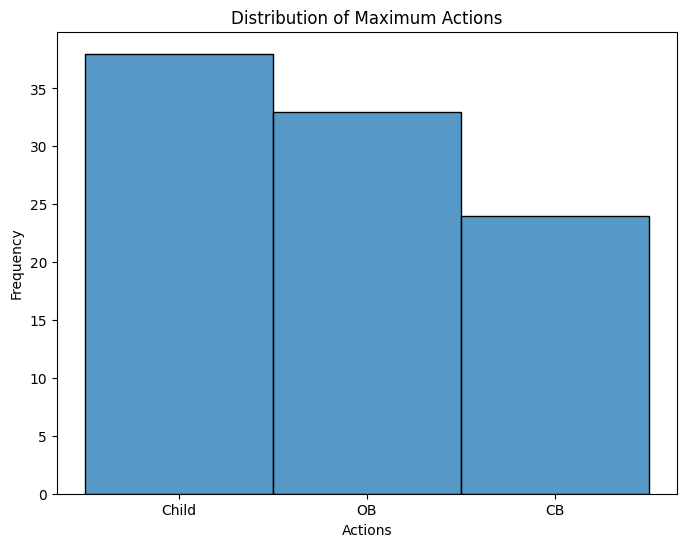

In [49]:
actions = []
for val in Q.values():
    # print action
    print(action_space[np.argmax(val)])
    actions.append(action_space[np.argmax(val)])

# Plot the distribution of actions
plt.figure(figsize=(8, 6))
sns.histplot(actions, bins=3, discrete=True)
plt.title("Distribution of Maximum Actions")
plt.xlabel("Actions")
plt.ylabel("Frequency")
plt.show()

## Try it on test set data of hotpot qa 

In [50]:
import json
import numpy as np
import random
from collections import defaultdict


# Function to select an action using the trained Q-table (no exploration)
def select_action(state):
    """ Select the best action using the trained Q-values. """
    max_q_value = np.max(Q[state])  # Get max Q-value
    best_actions = [action_space[i] for i, q in enumerate(Q[state]) if q == max_q_value]  # Get all actions with max Q-value
    print("best_actions", best_actions)
    return np.random.choice(best_actions)  # Choose randomly if multiple exist



# Function to make predictions on test data
def run_inference(test_data):
    """ Run inference on the test data using the trained Q-table. """
    correct_answers = 0
    total_parent_nodes = 0
    results = []
    
    for example in test_data:
        for node in example:
            if "fa" not in node:  # Only process parent nodes
                print(node["question_text"])
                state = tuple(get_state(node))  # Convert to tuple for Q-table lookup
                action = select_action(state)  # Use trained Q-table

                # Choose the answer based on the selected action
                if action == 'CB':
                    answer = node.get("cb_answer")[0]
                elif action == 'OB':
                    answer = node.get("ob_answer")[0]
                else:
                    if "child_answer" not in node:
                        action = "CB"
                        answer = node.get("cb_answer")[0]
                    else:
                        answer = node.get("child_answer")[0]

                if "unknown" in answer.lower().strip():
                    action = "CB"
                    answer = node.get("cb_answer")[0]
                    
                total_parent_nodes += 1
                final_answer, _ = q2gold[node["question_text"].strip()]
                print("final_answer", final_answer)
                print("answer", answer)
                if normalize_answer(answer) == normalize_answer(final_answer):
                    correct_answers += 1

                # Store results
                results.append({
                    "idx": node["idx"],
                    "question": node["question_text"],
                    "answer": answer,
                    "gold": final_answer,
                    "method": action
                })

    return results, correct_answers, total_parent_nodes

# Load test data
with open('test-testset-1.json', 'r') as file:
    test_data = json.load(file)

raw_data = [json.loads(line.strip()) for line in open('./hotpotqa__v2_test_random_500.jsonl')]
q2gold = {}
for item in raw_data:
    try:
        question = item['question_text'].strip()
        # TODO:: should add it later but run prompts again 
        # question = re.sub(r'\s+', ' ', question)
        gold = item['answers_objects'][0]['spans'][0]
        q2gold[question] = (gold, "")
    except Exception as e:
        # If question not found in question_decompositions, this means something went wrong in the proccess maybe in json parsing in prev steps of tree generation
        print("ERROR CASE", e)

# Run inference
Q = best_Q.copy()
rl_predictions, correct_answers, total_parent_nodes = run_inference(test_data)

# Print results
for pred in rl_predictions:  # Print only the first 10 for preview
    print(f"Q: {pred['question']}\nA: {pred['answer']} (Method: {pred['method']})\n")

What is the nationality of the foreign born victim of Singapore's caning punishment before Oliver Fricker experienced the same?
best_actions ['CB', 'OB', 'Child']
final_answer American
answer American.
Who wrote the 1970 international hit song Murray Head is most recognized for?
best_actions ['CB', 'OB', 'Child']
final_answer Andrew Lloyd Webber and Tim Rice
answer The writers of "Jesus Christ Superstar".
Where was the match held where Chicharito scored goals along with Antonio Valencia and Dimitar Berbatov?
best_actions ['CB', 'OB', 'Child']
final_answer Wembley Stadium
answer Old Trafford.
Where was Nexon who was composed by Adam Gubman located at?
best_actions ['CB', 'OB', 'Child']
final_answer South Korea
answer South Korea and the United States.
What event in 1920 was established by the director of the play "The Miracle"?
best_actions ['CB', 'OB', 'Child']
final_answer Salzburg Festival
answer the Salzburg Festival.
Chun Woo-hee's notable films include a South Korean horror film a

In [51]:
# Print the results
for result in rl_predictions:
    print(f"Node {result['idx']}:")
    print(f"  Question: {result['question']}")
    print(f"  Answer: {result['answer']}")
    print(f"  Gold Answer: {result['gold']}")
    print(f"  Method: {result['method']}")
    print()

# Calculate the accuracy
accuracy = (correct_answers / total_parent_nodes) * 100 if total_parent_nodes > 0 else 0
print(f"Total parent nodes: {total_parent_nodes}")
print(f"Times answer matches gold answer: {correct_answers}")
print(f"RL Solver match rate: {accuracy:.2f}%")

Node 2:
  Question: What is the nationality of the foreign born victim of Singapore's caning punishment before Oliver Fricker experienced the same?
  Answer: American.
  Gold Answer: American
  Method: OB

Node 2:
  Question: Who wrote the 1970 international hit song Murray Head is most recognized for?
  Answer: The writers of "Jesus Christ Superstar".
  Gold Answer: Andrew Lloyd Webber and Tim Rice
  Method: OB

Node 2:
  Question: Where was the match held where Chicharito scored goals along with Antonio Valencia and Dimitar Berbatov?
  Answer: Old Trafford.
  Gold Answer: Wembley Stadium
  Method: CB

Node 2:
  Question: Where was Nexon who was composed by Adam Gubman located at?
  Answer: South Korea and the United States.
  Gold Answer: South Korea
  Method: CB

Node 2:
  Question: What event in 1920 was established by the director of the play "The Miracle"?
  Answer: the Salzburg Festival.
  Gold Answer: Salzburg Festival
  Method: Child

Node 2:
  Question: Chun Woo-hee's notable

In [52]:
# comparing with original probtree solver
correct_answers = 0
total_parent_nodes = 0
results = []
for example in test_data:
    for node in example:
        if "fa" not in node:  # Only process parent nodes
            total_parent_nodes += 1
            answer = node.get("answer")[0]
            question_text = node.get("question_text", "").strip()
            final_answer, _ = q2gold[question_text]
            if normalize_answer(answer) == normalize_answer(final_answer):
                correct_answers += 1

            if node.get("answer") == node.get("cb_answer"):
                method = "CB"
            elif node.get("answer") == node.get("ob_answer"):
                method = "OB"
            else:
                method = "Child"
            
            results.append({
                "idx": node["idx"],
                "question": node["question_text"],
                "answer": answer,
                "gold": final_answer,
                "method": method
            })
            
# Print the results
for result in results:
    print(f"Node {result['idx']}:")
    print(f"  Question: {result['question']}")
    print(f"  Answer: {result['answer']}")
    print(f"  Gold Answer: {result['gold']}")
    print(f"  Method: {result['method']}")
    print()

# Calculate the accuracy
accuracy = (correct_answers / total_parent_nodes) * 100 if total_parent_nodes > 0 else 0
print(f"Total parent nodes: {total_parent_nodes}")
print(f"Times answer matches gold answer: {correct_answers}")
print(f"Probtree Solver match rate: {accuracy:.2f}%")

Node 2:
  Question: What is the nationality of the foreign born victim of Singapore's caning punishment before Oliver Fricker experienced the same?
  Answer: United States.
  Gold Answer: American
  Method: Child

Node 2:
  Question: Who wrote the 1970 international hit song Murray Head is most recognized for?
  Answer: The writers of "Jesus Christ Superstar".
  Gold Answer: Andrew Lloyd Webber and Tim Rice
  Method: OB

Node 2:
  Question: Where was the match held where Chicharito scored goals along with Antonio Valencia and Dimitar Berbatov?
  Answer: Old Trafford.
  Gold Answer: Wembley Stadium
  Method: CB

Node 2:
  Question: Where was Nexon who was composed by Adam Gubman located at?
  Answer: Tokyo, Japan.
  Gold Answer: South Korea
  Method: Child

Node 2:
  Question: What event in 1920 was established by the director of the play "The Miracle"?
  Answer: Salzburg Festival.
  Gold Answer: Salzburg Festival
  Method: CB

Node 2:
  Question: Chun Woo-hee's notable films include a 

In [53]:
# compare between rl_predictions and results
for rl_pred, prob_tree_result in zip(rl_predictions, results):
    if rl_pred['method'] == prob_tree_result['method']:
        continue
    print(f"Question: {rl_pred['question']}, Gold Answer: {q2gold[rl_pred['question']][0]}")
    print(f"RL Prediction: {rl_pred['answer']}, ProbTree Result: {prob_tree_result['answer']}")
    print(f"RL Method: {rl_pred['method']}, ProbTree Method: {prob_tree_result['method']}")
    print()


Question: What is the nationality of the foreign born victim of Singapore's caning punishment before Oliver Fricker experienced the same?, Gold Answer: American
RL Prediction: American., ProbTree Result: United States.
RL Method: OB, ProbTree Method: Child

Question: Where was Nexon who was composed by Adam Gubman located at?, Gold Answer: South Korea
RL Prediction: South Korea and the United States., ProbTree Result: Tokyo, Japan.
RL Method: CB, ProbTree Method: Child

Question: What event in 1920 was established by the director of the play "The Miracle"?, Gold Answer: Salzburg Festival
RL Prediction: the Salzburg Festival., ProbTree Result: Salzburg Festival.
RL Method: Child, ProbTree Method: CB

Question: Chun Woo-hee's notable films include a South Korean horror film about  a policeman who investigates a series of mysterious killings and what?, Gold Answer: illnesses
RL Prediction: illnesses., ProbTree Result: The Wailing.
RL Method: OB, ProbTree Method: CB

Question: What team ha

# RL Approach with deep learning

In [99]:
# Load the raw data and question decompositions
raw_data = [json.loads(line.strip()) for line in open('./hotpotqa__v2_dev_random_100.jsonl')]
q2dq = json.load(open("./question_decompositions-devset.json"))

# Create q2gold map
q2gold = {}
for item in raw_data:
    try:
        question = item['question_text'].strip()
        question = list(q2dq[question].keys())[0]
        gold = item['answers_objects'][0]['spans'][0]
        q_type = item["type"]
        q2gold[question] = (gold, q_type)
    except Exception as e:
        # Skip if question not found in question_decompositions
        continue

# Load the data to analyze
with open('test-devset.json', 'r') as file:
    data = json.load(file)


In [106]:
import torch
import torch.nn as nn
import torch.optim as optim

class QNetwork(nn.Module):
    def __init__(self, state_dim, action_dim, hidden_dim=128):
        super(QNetwork, self).__init__()
        self.fc1 = nn.Linear(state_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, action_dim)

    def forward(self, state):
        x = torch.relu(self.fc1(state))
        x = torch.relu(self.fc2(x))
        return self.fc3(x)

# def get_state(node, depth=0):
#     # Extract raw features
#     cb_logprob = node.get("cb_answer", [None, None])[1] or -100
#     ob_logprob = node.get("ob_answer", [None, None])[1] or -100
#     child_logprob = node.get("child_answer", [None, None])[1] or -100
#     has_children = 1 if len(node.get("sons", [])) else 0
#     question_length = len(node.get("question_text", "").split())
#     question_type = encode_question_type(node.get("question_text", ""))
#     num_children = len(node.get("sons", []))
#     cb_success_rate = get_success_rate("cb")
#     ob_success_rate = get_success_rate("ob")
#     child_success_rate = get_success_rate("child")

#     # Build state vector
#     state = [
#         cb_logprob,
#         ob_logprob,
#         # child_logprob,
#         has_children,
#         question_length,
#         question_type,
#         num_children,
#         cb_success_rate,
#         ob_success_rate,
#         child_success_rate
#     ]
#     return torch.FloatTensor(state)

def pad_or_truncate(logprobs, max_length=50, pad_value=-100):
    if len(logprobs) < max_length:
        # Pad with pad_value
        return logprobs + [pad_value] * (max_length - len(logprobs))
    else:
        # Truncate to max_length
        return logprobs[:max_length]

# # Define the reward function
# def get_reward(chosen_answer, gold_answer):
#     if normalize_answer(chosen_answer) == normalize_answer(gold_answer):
#         return 1
#     else:
#         return -1
    

from sentence_transformers import SentenceTransformer, util
# Load a pre-trained sentence embedding model
model = SentenceTransformer('all-MiniLM-L6-v2')
def get_reward(chosen_answer, gold_answer):
    # Compute embeddings for the chosen and gold answers
    chosen_embedding = model.encode(chosen_answer, convert_to_tensor=True)
    gold_embedding = model.encode(gold_answer, convert_to_tensor=True)
    # Compute cosine similarity
    similarity = util.cos_sim(chosen_embedding, gold_embedding).item()
    return similarity  # Reward is the similarity score (between -1 and 1)
    
# def get_state(node, depth=0, max_length=50):
#     # Extract raw features
#     cb_logprob = node.get("cb_answer", [None, None, None, []])[3] or []
#     ob_logprob = node.get("ob_answer", [None, None, None, []])[3] or []
#     child_logprob = node.get("child_answer", [None, None, None, []])[3] or []

#     # Pad or truncate logprobs
#     cb_logprob = pad_or_truncate(cb_logprob, max_length)
#     ob_logprob = pad_or_truncate(ob_logprob, max_length)
#     child_logprob = pad_or_truncate(child_logprob, max_length)

#     # Other features
#     has_children = 1 if len(node.get("sons", [])) else 0
#     question_length = len(node.get("question_text", "").split())
#     question_type = encode_question_type(node.get("question_text", ""))
#     num_children = len(node.get("sons", []))
#     cb_success_rate = get_success_rate("cb")
#     ob_success_rate = get_success_rate("ob")
#     child_success_rate = get_success_rate("child")

#     # Build state vector
#     state = (
#         cb_logprob +
#         ob_logprob +
#         # child_logprob +
#         [has_children, question_length, question_type, num_children, cb_success_rate, ob_success_rate, child_success_rate]
#     )
#     return torch.FloatTensor(state)

def get_state(node, depth=0, max_length=50):
    # Extract raw features
    cb_logprob = node.get("cb_answer", [None, None, None, []])[3] or []
    ob_logprob = node.get("ob_answer", [None, None, None, []])[3] or []
    # child_logprob = node.get("child_answer", [None, None, None, []])[3] or []

    # Pad or truncate logprobs each is of length 50
    cb_logprob = pad_or_truncate(cb_logprob, max_length)
    ob_logprob = pad_or_truncate(ob_logprob, max_length)
    # child_logprob = pad_or_truncate(child_logprob, max_length)

    # Other features (7)
    has_children = 1 if len(node.get("sons", [])) else 0
    question_length = len(node.get("question_text", "").split())
    question_type = encode_question_type(node.get("question_text", ""))
    num_children = len(node.get("sons", []))
    cb_success_rate = get_success_rate("cb")
    ob_success_rate = get_success_rate("ob")
    child_success_rate = get_success_rate("child")

    # Semantic features
    # Each embedding is a 384-dimensional vector and they are total 3 = 1152
    question_text = node.get("question_text", "")
    question_embedding = model.encode(question_text, convert_to_tensor=False)
    cb_answer_embedding = model.encode(node.get("cb_answer", [""])[0], convert_to_tensor=False)
    ob_answer_embedding = model.encode(node.get("ob_answer", [""])[0], convert_to_tensor=False)
    # child_answer_embedding = model.encode(node.get("child_answer", [""])[0], convert_to_tensor=False)

    # Confidence and uncertainty (total 2)
    cb_confidence = node.get("cb_answer", [None, None, None, []])[1] or 0.0
    ob_confidence = node.get("ob_answer", [None, None, None, []])[1] or 0.0
    child_confidence = node.get("child_answer", [None, None, None, []])[1] or 0.0

    # Structural features (total 2)
    tree_depth = depth
    tree_position = 0 if depth == 0 else 1  # 0 for root, 1 for intermediate/leaf

    # Temporal features (example: sliding window of last 3 actions) 
    # action_history = node.get("action_history", [0, 0, 0])  # Placeholder for action history
    # action_success_history = node.get("action_success_history", [0, 0, 0])  # Placeholder for success history

    # External knowledge features
    # num_retrieved_documents = node.get("num_retrieved_documents", 0)
    # entity_linking_confidence = node.get("entity_linking_confidence", 0.0)

    # Answer quality (total 2)
    cb_answer_length = len(node.get("cb_answer", [""])[0].split())
    ob_answer_length = len(node.get("ob_answer", [""])[0].split())
    # child_answer_length = len(node.get("child_answer", [""])[0].split())

    # Build state vector
    state = (
        cb_logprob +  # CB log probabilities
        ob_logprob +  # OB log probabilities
        [has_children, question_length, question_type, num_children, cb_success_rate, ob_success_rate, child_success_rate] +  # Basic features
        list(question_embedding) +  # Semantic embedding of the question
        list(cb_answer_embedding) +  # Semantic embedding of the CB answer
        list(ob_answer_embedding) +  # Semantic embedding of the OB answer
        [cb_confidence, ob_confidence] +  # Confidence scores for CB and OB
        [tree_depth, tree_position] +  # Structural features
        [cb_answer_length, ob_answer_length]  # Answer quality features
    )

    return torch.FloatTensor(state)

class DQNAgent:
    def __init__(self, state_dim, action_dim, hidden_dim=128, lr=1e-3, gamma=0.99):
        self.q_network = QNetwork(state_dim, action_dim, hidden_dim)
        self.target_network = QNetwork(state_dim, action_dim, hidden_dim)
        self.target_network.load_state_dict(self.q_network.state_dict())
        self.optimizer = optim.Adam(self.q_network.parameters(), lr=lr)
        self.gamma = gamma
        self.replay_buffer = []

    def select_action(self, state, epsilon):
        if random.random() < epsilon:
            if state[100] == 0: # has children = 0, because child is not possible
                return random.randint(0, len(action_space) - 2)
            else:
                return random.randint(0, len(action_space) - 1)
        else:
            with torch.no_grad():
                q_values = self.q_network(state)
                if state[100] == 0: # has children = 0
                    q_values[-1] = -float('inf')
                return torch.argmax(q_values).item()

    def train(self, batch_size):
        if len(self.replay_buffer) < batch_size:
            return
        batch = random.sample(self.replay_buffer, batch_size)
        states, actions, rewards, next_states, dones = zip(*batch)

        states = torch.stack(states)
        actions = torch.LongTensor(actions)
        rewards = torch.FloatTensor(rewards)
        next_states = torch.stack(next_states)
        dones = torch.FloatTensor(dones)

        # Compute Q-values for current states
        q_values = self.q_network(states).gather(1, actions.unsqueeze(1))

        # Compute target Q-values
        with torch.no_grad():
            next_q_values = self.target_network(next_states).max(1)[0]
            target_q_values = rewards + self.gamma * next_q_values * (1 - dones)

        # update the success rates
        for i, action in enumerate(actions):
            if rewards[i] == 1:
                update_success_rate(action_space[action], True)
            else:
                update_success_rate(action_space[action], False)

        # Compute loss and update the network
        loss = nn.MSELoss()(q_values.squeeze(), target_q_values)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

    def update_target_network(self):
        self.target_network.load_state_dict(self.q_network.state_dict())

In [107]:
# unload question_answering file from jupyter to refresh the code
# import importlib
# import question_answering
# importlib.reload(question_answering)
from importlib import reload  # Python 3.4+
import question_answering
question_answering = reload(question_answering)
from question_answering import aggregate_multihop_answer

In [108]:
state_dim = 100 + 7 + 1152 + 2 + 2 + 2 # Number of features in the state vector
action_dim = len(action_space)  # Number of actions (CB, OB, Child)
hidden_dim = 128  # Hidden layer size
lr = 1e-3  # Learning rate
gamma = 0.99  # Discount factor
epsilon = 1.0  # Initial exploration rate
epsilon_min = 0.01  # Minimum exploration rate
epsilon_decay = 0.995  # Decay rate for exploration
batch_size = 64  # Mini-batch size
num_episodes = 100  # Number of training episodes

agent = DQNAgent(state_dim, action_dim, hidden_dim, lr, gamma)

In [ ]:
max_accuracy = 0
best_agent = None

# Set model to training mode
agent.q_network.train()
for episode in range(num_episodes):
    print(f"Episode {episode + 1}/{num_episodes}")
    total_reward = 0
    correct_answers = 0
    total_parent_nodes = 0

    for example in data:
        for node in example:
            if "fa" not in node:  # Only process parent nodes
                total_parent_nodes += 1
                state = get_state(node)  # Get the current state
                action = agent.select_action(state, epsilon)  # Select an action
                chosen_answer = None
                fallback_used = False  # Track if a fallback was used

                # Simulate the action (choose answer based on action)
                if action == 0:  # CB
                    chosen_answer = node.get("cb_answer", [None])
                elif action == 1:  # OB
                    chosen_answer = node.get("ob_answer", [None])
                elif action == 2:  # Child
                    # chosen_answer = node.get("child_answer", [None])
                    # Solve child nodes
                    # print(example)
                    tree_with_answers_chosen_by_agent = copy.deepcopy(example)
                    
                    child_experiences = []
                    for child_idx in node.get("sons", []):
                        child = example[child_idx]
                        # print(child["question_text"])
                        child_state = get_state(child, depth=1)
                        child_action = agent.select_action(child_state, epsilon)
                        if child_action == 0:  # CB
                            child_answer = child.get("cb_answer", [None])
                            # print("child_answer by cb: ", child_answer)
                            if "unknown" in child_answer[0].lower().strip():
                                child_action = 1 # Fallback to OB in case cb generates unknown answer
                                child_answer = child.get("ob_answer", [None])
                        elif child_action == 1:  # OB
                            child_answer = child.get("ob_answer", [None])
                            # print("child_answer by ob: ", child_answer)
                            if "unknown" in child_answer[0].lower().strip():
                                child_action = 0 # Fallback to CB in case ob generates unknown answer
                                child_answer = child.get("cb_answer", [None])

                        # print(f"action used: {action_space[child_action]} , child_answer: {child_answer}")
                        
                        # I overwrite the child answer with the answer chosen by the agent for the child, so that the parent can use it
                        # and to also train the children nodes' answers selection
                        tree_with_answers_chosen_by_agent[child_idx]["answer"] = child_answer

                        # Store children experience
                        child_experiences.append((child_state, child_action, 0, child_state, False))  # Reward is 0 (will be updated later)

                    # print("tree_with_answers_chosen_by_agent", tree_with_answers_chosen_by_agent)
                    # Generate child_answer for the parent node
                    for node_ in tree_with_answers_chosen_by_agent:
                        question = node_["question_text"].strip()
                        ref_tokens = re.findall(r"<\d+>", question)
                        topic_entities = []
                        # print("question, ref_tokens", question, ref_tokens)
                        # return
                        for ref_token in ref_tokens:
                            if "fa" in node_ and int(ref_token[1:-1]) <= len(tree_with_answers_chosen_by_agent[node_["fa"]]["sons"]):
                                ref_idx = tree_with_answers_chosen_by_agent[node_["fa"]]["sons"][int(ref_token[1:-1])-1]
                                # print("ref_idx", ref_idx)
                                if "answer" in tree_with_answers_chosen_by_agent[ref_idx]:
                                    question = question.replace(ref_token, tree_with_answers_chosen_by_agent[ref_idx]["answer"][0])
                                    topic_entities.append(tree_with_answers_chosen_by_agent[ref_idx]["answer"][0])
                        node_["question"] = question

                    # print("tree_with_answers_chosen_by_agent", tree_with_answers_chosen_by_agent)
                    node["child_answer"], node["answer"] = aggregate_multihop_answer(node, tree_with_answers_chosen_by_agent)
                    # print("node['child_answer']: ", node["child_answer"])
                    chosen_answer = node["child_answer"]

                # if the chosen answer is unknown, then try another action
                if "unknown" in chosen_answer[0].lower().strip():
                    fallback_used = True
                    # i fallback to cb if ob,child generate unknown answer and fallback to ob if cb generate unknown answer
                    if action == 0:  # CB
                        fallback_action = 1  # OB
                        chosen_answer = node.get("ob_answer", [None])
                    elif action == 1:  # OB
                        fallback_action = 0
                        chosen_answer = node.get("cb_answer", [None])
                    elif action == 2:  # Child
                        fallback_action = 0
                        chosen_answer = node.get("cb_answer", [None])

                # Compute reward
                gold_answer, _ = q2gold[node["question_text"].strip()]
                reward = get_reward(chosen_answer[0], gold_answer)
                total_reward += reward

                # Check if the answer is correct
                if normalize_answer(chosen_answer[0]) == normalize_answer(gold_answer):
                    correct_answers += 1

                # Get the next state
                next_state = get_state(node)  # In this case, the next state is the same as the current state

                # Store the experience in the replay buffer
                # agent.replay_buffer.append((state, action, reward, next_state, False))  # False for "done"
                
                if not fallback_used:
                    # Store the original action if no fallback was used
                    agent.replay_buffer.append((state, action, reward, next_state, False))  # False for "done"
                else:
                    # Store the fallback action as a separate experience
                    agent.replay_buffer.append((state, fallback_action, reward, next_state, False))
                

                # Propagate reward to child nodes if Child was chosen
                if action == 2:
                    num_children = len(node.get("sons", []))
                    child_reward = reward / num_children  # Distribute the reward equally, because if you give "reward" to each child, we 
                    # will have a total reward for the parent node that is equal to the sum of the rewards of the children, which is not correct
                    for child_state, child_action, _, next_child_state, done in child_experiences:
                        agent.replay_buffer.append((child_state, child_action, child_reward, next_child_state, done))

                # Train the agent using a mini-batch from the replay buffer
                agent.train(batch_size)

    # Decay epsilon
    epsilon = max(epsilon_min, epsilon * epsilon_decay)

    # Update the target network periodically
    if episode % 10 == 0:
        agent.update_target_network()

    # Print episode statistics
    accuracy = (correct_answers / total_parent_nodes) * 100 if total_parent_nodes > 0 else 0
    if accuracy > max_accuracy:
        max_accuracy = accuracy
        best_agent = copy.deepcopy(agent)
    print(f"Total Reward: {total_reward}")
    print(f"Accuracy: {accuracy:.2f}%")
    print(f"Epsilon: {epsilon:.4f}")
    print()

Episode 1/100
Into which river does Pack Creek run after it goes through the Spanish Valley?
child_answer by ob:  ['Colorado River.', -0.021078500010388176, 'Pack Creek flows through Spanish Valley north northwestward into Moab Valley toward its confluence with the Colorado River. So the answer is: Colorado River.', [-0.32421875, -1.1563301e-05, -0.049072266, -0.08496094, -0.0028076172, 0, -0.001045227, -2.9921532e-05, 0, -7.2717667e-06, -1.013279e-05, -3.695488e-06, 0, -0.0015563965, -1.1920929e-07, -4.7683716e-07, -1.5497208e-06, 0, 0, -1.1920929e-07, 0, -9.536743e-07, -0.00010538101, -2.6226044e-06, 0, 0, 0, -0.12695312, -2.6226044e-06, -0.00018692017, -1.4305115e-06]]
What is the length of <1>?
child_answer by ob:  ['1450 mi.', -0.09902609393720417, 'The length of the Colorado River is 1450 mi. So the answer is: 1450 mi.', [-0.1640625, -0.38671875, -1.1920929e-07, -0.02319336, -4.7683716e-07, 0, -0.0008125305, -0.0057373047, -0.014160156, 0, -0.57421875, -0.01940918, -0.00045204163

KeyboardInterrupt: 

In [ ]:
torch.save(agent.q_network.state_dict(), "dqn_agent.pth")
torch.save(best_agent.q_network.state_dict(), "dqn_best_agent.pth")

## Try it on test set data of hotpot qa 

In [84]:
# Evaluate the agent on the test data
def evaluate_agent(agent, data):
    agent.q_network.eval()  # Set the model to evaluation mode
    correct_answers = 0
    total_parent_nodes = 0
    results = []
    for example in data:
        for node in example:
            if "fa" not in node:  # Only process parent nodes
                total_parent_nodes += 1
                state = get_state(node)
                action = agent.select_action(state, epsilon=0)  # No exploration during evaluation
                chosen_answer = None
                fallback_used = False  # Track if a fallback was used
                fallback_action = None

                # Simulate the action (choose answer based on action)
                if action == 0:  # CB
                    chosen_answer = node.get("cb_answer", [None])[0]
                    if "unknown" in chosen_answer.lower().strip():  # Fallback to OB
                        chosen_answer = node.get("ob_answer", [None])[0]
                        fallback_action = 1
                        fallback_used = True
                elif action == 1:  # OB
                    chosen_answer = node.get("ob_answer", [None])[0]
                    if "unknown" in chosen_answer.lower().strip():  # Fallback to CB
                        chosen_answer = node.get("cb_answer", [None])[0]
                        fallback_action = 0
                        fallback_used = True
                elif action == 2:  # Child
                    tree_with_answers_chosen_by_agent = copy.deepcopy(example)
                    for child_idx in node.get("sons", []):
                        child = example[child_idx]
                        child_state = get_state(child, depth=1)
                        child_action = agent.select_action(child_state, epsilon=0)  # Greedy policy
                        if child_action == 0:  # CB
                            child_answer = child.get("cb_answer", [None])
                            if "unknown" in child_answer[0].lower().strip():  # Fallback to OB
                                child_answer = child.get("ob_answer", [None])
                        elif child_action == 1:  # OB
                            child_answer = child.get("ob_answer", [None])
                            if "unknown" in child_answer[0].lower().strip():  # Fallback to CB
                                child_answer = child.get("cb_answer", [None])

                        tree_with_answers_chosen_by_agent[child_idx]["answer"] = child_answer

                    # Generate child_answer for the parent node
                    print("tree_with_answers_chosen_by_agent", tree_with_answers_chosen_by_agent)
                    node["child_answer"], node["answer"] = aggregate_multihop_answer(node, tree_with_answers_chosen_by_agent)
                    chosen_answer = node["child_answer"][0]
                    if "unknown" in chosen_answer.lower().strip():  # Fallback to CB or OB
                        chosen_answer = node.get("cb_answer", [None])[0]  # Try CB first
                        # fallback_used = True
                        if "unknown" in chosen_answer.lower().strip():
                            chosen_answer = node.get("ob_answer", [None])[0]  # Try OB next

                # Compute reward
                gold_answer, _ = q2gold[node["question_text"].strip()]
                if chosen_answer and normalize_answer(chosen_answer) == normalize_answer(gold_answer):
                    correct_answers += 1

                # Store results
                results.append({
                    "idx": node["idx"],
                    "question": node["question_text"],
                    "answer": chosen_answer,
                    "gold": gold_answer,
                    "method": action_space[action] if not fallback_used else action_space[fallback_action]
                })

    accuracy = (correct_answers / total_parent_nodes) * 100 if total_parent_nodes > 0 else 0
    print(f"Evaluation Accuracy: {accuracy:.2f}%")
    return results, correct_answers, total_parent_nodes

# Load test data
with open('test-testset-1.json', 'r') as file:
    test_data = json.load(file)

raw_data = [json.loads(line.strip()) for line in open('./hotpotqa__v2_test_random_500.jsonl')]
q2gold = {}
for item in raw_data:
    try:
        question = item['question_text'].strip()
        # TODO:: should add it later but run prompts again 
        # question = re.sub(r'\s+', ' ', question)
        gold = item['answers_objects'][0]['spans'][0]
        q2gold[question] = (gold, "")
    except Exception as e:
        # If question not found in question_decompositions, this means something went wrong in the proccess maybe in json parsing in prev steps of tree generation
        print("ERROR CASE", e)

# Evaluate the agent on the test data
rl_predictions, correct_answers, total_parent_nodes = evaluate_agent(agent, test_data)

tree_with_answers_chosen_by_agent [{'idx': 0, 'question_text': 'Which 1970 international hit song is Murray Head most recognized for?', 'sons': [], 'qd_logprob': None, 'fa': 2, 'question': 'Which 1970 international hit song is Murray Head most recognized for?', 'cb_answer': ['Jesus Christ Superstar.', -0.0934109261805143, 'Murray Head is a British actor and singer. He is most recognized for his 1970 international hit song "Jesus Christ Superstar". So the answer is: Jesus Christ Superstar.', [-0.10986328, -0.00020503998, -2.1457672e-06, -0.00037193298, -0.390625, -0.013244629, -0.00077819824, -0.000333786, -0.0015945435, -0.014587402, -0.03881836, -0.001083374, -0.0021514893, -0.00033187866, -1.5735626e-05, -0.6484375, -1.109375, -1.3113022e-06, -0.0009994507, -0.004547119, -8.34465e-07, -8.583069e-06, -0.0032043457, -0.25, -1.1920929e-05, -9.894371e-06, -8.34465e-07, -0.024902344, -0.122558594, -1.1444092e-05, 0, 0, 0, -0.0011825562, -3.5762787e-07, -3.5762787e-07, -1.1920929e-07, -0.0

In [85]:
# Print the results of the agent
for result in rl_predictions:
    print(f"Node {result['idx']}:")
    print(f"  Question: {result['question']}")
    print(f"  Answer: {result['answer']}")
    print(f"  Gold Answer: {result['gold']}")
    print(f"  Method: {result['method']}")
    print()

# Calculate the accuracy
accuracy = (correct_answers / total_parent_nodes) * 100 if total_parent_nodes > 0 else 0
print(f"Total parent nodes: {total_parent_nodes}")
print(f"Times answer matches gold answer: {correct_answers}")
print(f"RL Solver match rate: {accuracy:.2f}%")

Node 2:
  Question: What is the nationality of the foreign born victim of Singapore's caning punishment before Oliver Fricker experienced the same?
  Answer: American.
  Gold Answer: American
  Method: OB

Node 2:
  Question: Who wrote the 1970 international hit song Murray Head is most recognized for?
  Answer: Andrew Lloyd Webber.
  Gold Answer: Andrew Lloyd Webber and Tim Rice
  Method: Child

Node 2:
  Question: Where was the match held where Chicharito scored goals along with Antonio Valencia and Dimitar Berbatov?
  Answer: Old Trafford.
  Gold Answer: Wembley Stadium
  Method: Child

Node 2:
  Question: Where was Nexon who was composed by Adam Gubman located at?
  Answer: South Korea and the United States.
  Gold Answer: South Korea
  Method: CB

Node 2:
  Question: What event in 1920 was established by the director of the play "The Miracle"?
  Answer: Salzburg Festival.
  Gold Answer: Salzburg Festival
  Method: CB

Node 2:
  Question: Chun Woo-hee's notable films include a Sout

In [86]:
# comparing with original probtree solver
correct_answers = 0
total_parent_nodes = 0
results = []
for example in test_data:
    for node in example:
        if "fa" not in node:  # Only process parent nodes
            total_parent_nodes += 1
            answer = node.get("answer")[0]
            question_text = node.get("question_text", "").strip()
            final_answer, _ = q2gold[question_text]
            if normalize_answer(answer) == normalize_answer(final_answer):
                correct_answers += 1

            if node.get("answer") == node.get("cb_answer"):
                method = "CB"
            elif node.get("answer") == node.get("ob_answer"):
                method = "OB"
            else:
                method = "Child"
            
            results.append({
                "idx": node["idx"],
                "question": node["question_text"],
                "answer": answer,
                "gold": final_answer,
                "method": method
            })
            
# Print the results
for result in results:
    print(f"Node {result['idx']}:")
    print(f"  Question: {result['question']}")
    print(f"  Answer: {result['answer']}")
    print(f"  Gold Answer: {result['gold']}")
    print(f"  Method: {result['method']}")
    print()

# Calculate the accuracy
accuracy = (correct_answers / total_parent_nodes) * 100 if total_parent_nodes > 0 else 0
print(f"Total parent nodes: {total_parent_nodes}")
print(f"Times answer matches gold answer: {correct_answers}")
print(f"Probtree Solver match rate: {accuracy:.2f}%")

Node 2:
  Question: What is the nationality of the foreign born victim of Singapore's caning punishment before Oliver Fricker experienced the same?
  Answer: United States.
  Gold Answer: American
  Method: Child

Node 2:
  Question: Who wrote the 1970 international hit song Murray Head is most recognized for?
  Answer: The writers of "Jesus Christ Superstar".
  Gold Answer: Andrew Lloyd Webber and Tim Rice
  Method: Child

Node 2:
  Question: Where was the match held where Chicharito scored goals along with Antonio Valencia and Dimitar Berbatov?
  Answer: Old Trafford.
  Gold Answer: Wembley Stadium
  Method: Child

Node 2:
  Question: Where was Nexon who was composed by Adam Gubman located at?
  Answer: Tokyo, Japan.
  Gold Answer: South Korea
  Method: Child

Node 2:
  Question: What event in 1920 was established by the director of the play "The Miracle"?
  Answer: Salzburg Festival.
  Gold Answer: Salzburg Festival
  Method: CB

Node 2:
  Question: Chun Woo-hee's notable films incl

In [87]:
# compare between rl_predictions and results
for rl_pred, prob_tree_result in zip(rl_predictions, results):
    if rl_pred['method'] == prob_tree_result['method'] or rl_pred['answer'] == prob_tree_result['answer']:
        continue
    print(f"Question: {rl_pred['question']}")
    print(f"Gold Answer: {q2gold[rl_pred['question']][0]}")
    print(f"RL Prediction: {rl_pred['answer']}, ProbTree Result: {prob_tree_result['answer']}")
    print(f"RL Method: {rl_pred['method']}, ProbTree Method: {prob_tree_result['method']}")
    print()


Question: What is the nationality of the foreign born victim of Singapore's caning punishment before Oliver Fricker experienced the same?
Gold Answer: American
RL Prediction: American., ProbTree Result: United States.
RL Method: OB, ProbTree Method: Child

Question: Where was Nexon who was composed by Adam Gubman located at?
Gold Answer: South Korea
RL Prediction: South Korea and the United States., ProbTree Result: Tokyo, Japan.
RL Method: CB, ProbTree Method: Child

Question: What team had Tony Roberts replaced by an American sportscaster from Buffalo, New York when he retired?
Gold Answer: Notre Dame Fighting Irish football
RL Prediction: Buffalo Sabres., ProbTree Result: Notre Dame.
RL Method: CB, ProbTree Method: OB

Question: The 1978 NBA World Championship Series had as MVP which Hall of Fame class member of 1988?
Gold Answer: Westley Sissel Unseld
RL Prediction: Bill Walton., ProbTree Result: Wes Unseld.
RL Method: CB, ProbTree Method: Child

Question: Which star in the Maltese